In [1]:
import time
import numpy as np
import pandas as pd
# settings to display all columns
pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.graphics.gofplots import qqplot
import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.impute import SimpleImputer
# SimpleImputer does not have get_feature_names_out, so we need to add it manually.
SimpleImputer.get_feature_names_out = (lambda self, names = None: self.feature_names_in_)
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
from sklearn.pipeline import Pipeline, make_pipeline, make_union
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.model_selection import cross_val_score, cross_validate, learning_curve, train_test_split, RandomizedSearchCV, GridSearchCV, KFold
from sklearn.feature_selection import SelectPercentile, mutual_info_regression

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn import set_config; set_config(display='diagram')
from sklearn.metrics import mean_squared_error, make_scorer
import sklearn.metrics as metrics

from xgboost import XGBRegressor
from sklearn_evaluation import plot

import pickle

from housing_crawler.ads_table_processing import get_processed_ads_table
from housing_crawler.utils import return_significative_coef

%load_ext autoreload
%autoreload 2

In [2]:
# sklearndf is an sklearn alternative that returns dataframes from transformers instead of np.arrays
# https://github.com/BCG-Gamma/sklearndf
from sklearndf.transformation import ColumnTransformerDF,OneHotEncoderDF,SimpleImputerDF,StandardScalerDF,RobustScalerDF,MinMaxScalerDF
from sklearndf.pipeline import PipelineDF

# Prepare data

## Obtain data for WGs

In [3]:
# Set target for estimations
market_type_filter = 'WG' # WG, Single-room flat, Apartment
target='price_per_sqm_cold' # price_per_sqm_cold, price_euros
target_log_transform = False
city='allcities'

In [4]:
df_original = get_processed_ads_table()


===> Loaded all_encoded.csv locally
===> ads_OSM.csv saved locally


In [5]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31488 entries, 0 to 31499
Columns: 146 entries, id to cos_day_week_int
dtypes: Float64(2), Int64(1), datetime64[ns](3), float64(117), int64(5), object(18)
memory usage: 35.4+ MB


In [6]:
ads_feat_df = df_original[df_original['details_searched']==1]
# ads_feat_df = ads_feat_df[ads_feat_df['city'].isin(['Berlin'])]#, 'München', 'Hamburg', 'Stuttgart', 'Köln', 'Münster', 'Leipzig', 'Frankfurt am Main'])]
ads_feat_df = ads_feat_df.set_index('id')

## Remove duplicates if exist

In [7]:
# Number of duplicate data points
# It's very likely zero cause I already removed dulicated IDs during processing
ads_feat_df.duplicated().sum()

0

## Filter data accordingly

In [8]:
# Filter only ads that have been searched for details (search added from august on)
df_filtered = ads_feat_df.copy()
df_filtered = df_filtered[df_filtered['type_offer_simple']==market_type_filter]
df_filtered = df_filtered[df_filtered['km_to_centroid'].notna()]
df_filtered = df_filtered.drop(columns=['details_searched','type_offer_simple'])


if city != 'allcities':
    df_filtered = df_filtered[df_filtered['city']==city]
    df_filtered = df_filtered.drop(columns=['city'])

if target_log_transform:
    df_filtered[target] = np.log2(df_filtered[target])
    
df_filtered.describe()

,commercial_landlord,price_euros,size_sqm,available_rooms,capacity,available_spots_wg,male_flatmates,female_flatmates,diverse_flatmates,published_at,latitude,longitude,cold_rent_euros,mandatory_costs_euros,extra_costs_euros,transfer_costs_euros,deposit,zip_code,wg_possible,building_floor,public_transport_distance,schufa_needed,home_total_size,min_age_flatmates,max_age_flatmates,min_age_searched,max_age_searched,construction_year,energy_usage,energy_efficiency_class,price_per_sqm_warm,price_per_sqm_cold,number_languages,internet_speed,toilet,internet_dsl,internet_wlan,internet_flatrate,shower_type_badewanne,shower_type_dusche,floor_type_dielen,floor_type_parkett,floor_type_laminat,floor_type_teppich,floor_type_fliesen,floor_type_pvc,floor_type_fußbodenheizung,extras_waschmaschine,extras_spuelmaschine,extras_terrasse,extras_balkon,extras_garten,extras_gartenmitbenutzung,extras_keller,extras_aufzug,extras_haustiere,extras_fahrradkeller,extras_dachboden,languages_deutsch,languages_englisch,wg_type_studenten,wg_type_keine_zweck,wg_type_maenner,wg_type_business,wg_type_wohnheim,wg_type_vegetarisch_vegan,wg_type_alleinerziehende,wg_type_funktionale,wg_type_berufstaetigen,wg_type_gemischte,wg_type_mit_kindern,wg_type_verbindung,wg_type_lgbtqia,wg_type_senioren,wg_type_inklusive,wg_type_wg_neugruendung,tv_kabel,tv_satellit,days_available,furniture_numerical,kitchen_numerical,smoking_numerical,room_size_house_fraction,flat_with_kids,km_to_centroid,comfort_leisure_spots,comfort_warehouse,activities_education,mobility_public_transport_bus,activities_economic,comfort_industrial,activities_goverment,social_life_eating,comfort_comfort_spots,social_life_culture,activities_supermarket,activities_public_service,social_life_community,comfort_leisure_mass,activities_educational,mobility_street_secondary,mobility_public_transport_rail,activities_retail,social_life_night_life,comfort_green_natural,comfort_railway,mobility_bike_infraestructure,comfort_green_forests,mobility_street_primary,comfort_lakes,activities_health_regional,activities_health_local,comfort_green_space,comfort_rivers,activities_post,comfort_green_parks,comfort_street_motorway,sin_degrees_to_centroid,cos_degrees_to_centroid,sin_published_at,cos_published_at,sin_day_week_int,cos_day_week_int
count,9576.000000,9576.000000,9576.000000,9576.0,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,7919.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9561.000000,9576.0,8503.000000,8387.000000,9576.000000,6648.000000,7189.000000,6716.000000,9576.000000,9576.000000,1097.000000,335.000000,487.000000,9576.000000,9576.000000,9576.000000,2896.000000,17.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.00000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.00000,9576.000000,9576.000000,9576.000000,9576.00000,9576.000000,9576.000000,6648.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9.576000e+03,9576.000000,9576.000000,9576.000000,9.576000e+03,9576.0,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9.576000e+03,9576.000000,9576.0,9576.000000,9576.000000,9576.0,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,7.919000e+03,7919.000000,9576.000000,9576.000000
mean,0.007206,481.440685,17.262114,1.0,3.248016,1.249791,0.957498,1.024123,0.016604,15.010986,50.924448,10.212948,386.805347,59.194027,6.789683,30.592732,570.572891,44958.694697,1.0,2.000294,3.237153,0.086048,91.888538,24.463764,29.976325,13.672201,58.793233,1946.05378

# Preprocessing pipeline

In [9]:
X = df_filtered.drop(columns=target)
y = df_filtered[[target]].reset_index()

## Select columns per pipeline

In [10]:
columns_to_remove = []

In [11]:
features_OSM = [
                'comfort_leisure_spots',
                'comfort_warehouse',
                'activities_education',
                'mobility_public_transport_bus',
                'activities_economic',
                'comfort_industrial', # Has not been blurried?
#                 'activities_goverment', # I can't even plot it. There's something weird
                'social_life_eating',
                'comfort_comfort_spots',
                'social_life_culture',
#                 'activities_supermarket', # I can't even plot it. There's something weird
#                 'activities_public_service', # Data is constant
                'social_life_community',
                'comfort_leisure_mass',
                'activities_educational',
                'mobility_street_secondary', # Has not been blurried?
                'mobility_public_transport_rail',
                'activities_retail', # Has not been blurried?
                'social_life_night_life',
#                 'comfort_green_natural', # I can't even plot it. There's something weird
                'comfort_railway', # Has not been blurried?
                'mobility_bike_infraestructure', # Has not been blurried
#                 'comfort_green_forests', # Data is constant
                'mobility_street_primary', # Has not been blurried?
                'comfort_lakes', # Has not been blurried?
#                 'activities_health_regional', # Data is constant
                'activities_health_local',
                'comfort_green_space', # Has not been blurried
#                 'comfort_rivers', # I can't even plot it. There's something weird
                'activities_post',
                'comfort_green_parks', # Has not been blurried?
#                 'comfort_street_motorway' # Has not been blurried. Empty?
]

In [12]:
# features_already_OHE
if market_type_filter == 'WG':
    features_already_OHE = ['tv_kabel','tv_satellit',

                'shower_type_badewanne','shower_type_dusche',

               'floor_type_dielen','floor_type_parkett','floor_type_laminat','floor_type_teppich',
               'floor_type_fliesen','floor_type_pvc','floor_type_fußbodenheizung',

               'extras_waschmaschine','extras_spuelmaschine','extras_terrasse','extras_balkon',
               'extras_garten','extras_gartenmitbenutzung','extras_keller','extras_aufzug',
               'extras_haustiere','extras_fahrradkeller','extras_dachboden',

               'languages_deutsch','languages_englisch',

               'wg_type_studenten','wg_type_keine_zweck','wg_type_maenner','wg_type_business',
               'wg_type_wohnheim','wg_type_vegetarisch_vegan','wg_type_alleinerziehende','wg_type_funktionale',
               'wg_type_berufstaetigen','wg_type_gemischte','wg_type_mit_kindern','wg_type_verbindung',
               'wg_type_lgbtqia','wg_type_senioren','wg_type_inklusive','wg_type_wg_neugruendung',

               'internet_dsl','internet_wlan','internet_flatrate']
elif market_type_filter == 'Apartment':
    features_already_OHE = ['tv_kabel','tv_satellit',

                'shower_type_badewanne','shower_type_dusche',

               'floor_type_dielen','floor_type_parkett','floor_type_laminat','floor_type_teppich',
               'floor_type_fliesen','floor_type_pvc','floor_type_fußbodenheizung',

               'extras_waschmaschine','extras_spuelmaschine','extras_terrasse','extras_balkon',
               'extras_garten','extras_gartenmitbenutzung','extras_keller','extras_aufzug',
               'extras_haustiere','extras_fahrradkeller','extras_dachboden',

               'wg_possible',

               'internet_dsl','internet_wlan','internet_flatrate']
else:
    features_already_OHE = ['tv_kabel','tv_satellit',

                'shower_type_badewanne','shower_type_dusche',

               'floor_type_dielen','floor_type_parkett','floor_type_laminat','floor_type_teppich',
               'floor_type_fliesen','floor_type_pvc','floor_type_fußbodenheizung',

               'extras_waschmaschine','extras_spuelmaschine','extras_terrasse','extras_balkon',
               'extras_garten','extras_gartenmitbenutzung','extras_keller','extras_aufzug',
               'extras_haustiere','extras_fahrradkeller','extras_dachboden']


In [13]:
# cols_PowerTrans_SimpImpMean
if market_type_filter == 'WG':
    cols_PowerTrans_SimpImpMean = ['km_to_centroid',#'size_sqm',
                                'min_age_flatmates', 'max_age_flatmates', 'home_total_size', 'days_available',
                                'room_size_house_fraction','energy_usage']
else:
    cols_PowerTrans_SimpImpMean = ['km_to_centroid', 'days_available'
                                'construction_year','energy_usage']

# cols_PowerTrans_SimpImpMedian_MinMaxScaler
if market_type_filter == 'WG':
    cols_PowerTrans_SimpImpMedian_MinMaxScaler = features_OSM +\
    ['capacity', 'min_age_searched', 'max_age_searched','public_transport_distance','number_languages', 'energy_efficiency_class']
else:
    cols_PowerTrans_SimpImpMedian_MinMaxScaler = features_OSM +\
    ['public_transport_distance', 'energy_efficiency_class']


# cols_SimpImpMean_MinMaxScaler
if market_type_filter == 'WG':
    cols_SimpImpMean_MinMaxScaler = ['internet_speed','sin_degrees_to_centroid','cos_degrees_to_centroid']
else:
    cols_SimpImpMean_MinMaxScaler = ['sin_degrees_to_centroid','cos_degrees_to_centroid']


# cols_SimpImpMedian_MinMaxScaler
if market_type_filter == 'WG':
    cols_SimpImpMedian_MinMaxScaler = ['commercial_landlord',
                                'male_flatmates', 'female_flatmates', 'diverse_flatmates','flat_with_kids',
                                'schufa_needed','smoking_numerical', 'building_floor',
                                'furniture_numerical'] + features_already_OHE
elif market_type_filter == 'Apartment':
    cols_SimpImpMedian_MinMaxScaler = ['commercial_landlord',
                                'schufa_needed',
                                'building_floor', 'toilet',
                                'furniture_numerical', 'kitchen_numerical', 'available_rooms'] + features_already_OHE
else:
    cols_SimpImpMedian_MinMaxScaler = ['commercial_landlord',
                                'schufa_needed',
                                'building_floor', 'toilet',
                                'furniture_numerical', 'kitchen_numerical'] + features_already_OHE


# cols_PowerTrans_SimpImpMedian_MinMaxScaler
cols_SimpImpConst0_PowerTrans_MinMaxScaler = ['transfer_costs_euros']


# cols_PowerTrans_SimpImpMedian_MinMaxScaler
if market_type_filter == 'WG':
    cols_SimpImpConstNoAns_OHE = ['rental_length_term','gender_searched','building_type','heating', 'parking']
else:
    cols_SimpImpConstNoAns_OHE = ['rental_length_term','building_type','heating', 'parking']

if city == 'allcities':
    cols_SimpImpConstNoAns_OHE += ['city']


original_cols = cols_PowerTrans_SimpImpMean+cols_PowerTrans_SimpImpMedian_MinMaxScaler+cols_SimpImpMean_MinMaxScaler\
   +cols_SimpImpMedian_MinMaxScaler+cols_SimpImpConst0_PowerTrans_MinMaxScaler+cols_SimpImpConstNoAns_OHE

len(original_cols)

99

## Build the imputter/scaler pairs

In [14]:
PowerTrans_SimpImpMean = Pipeline([
    ('SimpleImputer', SimpleImputer(strategy="mean")),
    ('PowerTransformer', PowerTransformer())    
])

PowerTrans_SimpImpMedian_MinMaxScaler = Pipeline([
    ('SimpleImputer', SimpleImputer(strategy="median")),
    ('PowerTransformer', PowerTransformer()),
    ('MinMaxScaler', MinMaxScaler())
])

SimpImpMean_MinMaxScaler = Pipeline([
    ('SimpleImputer', SimpleImputer(strategy="mean")),
    ('MinMaxScaler', MinMaxScaler())
])

SimpImpMedian_MinMaxScaler = Pipeline([
    ('SimpleImputer', SimpleImputer(strategy="median")),
    ('MinMaxScaler', MinMaxScaler())
])

SimpImpConst0_PowerTrans_MinMaxScaler = Pipeline([
    ('SimpleImputer', SimpleImputer(strategy="constant", fill_value=0)),
    ('PowerTransformer', PowerTransformer()),
    ('MinMaxScaler', MinMaxScaler())
])

SimpImpConstNoAns_OHE = Pipeline([
    ('SimpleImputer', SimpleImputer(strategy="constant", fill_value='no_answer')),
    ('OHE', OneHotEncoder(sparse=False, drop='if_binary', categories='auto'))
])

## Build column transformer pipeline

In [15]:
class columnDropperTransformer(ColumnTransformer):
    def __init__(self,columns):
        self.columns=columns

    def transform(self,X,y=None):
        return X.drop(self.columns,axis=1)

    def fit(self, X, y=None):
        return self 

In [16]:
preprocessor_transformer = ColumnTransformer([
    ('pipeline-1', PowerTrans_SimpImpMean, cols_PowerTrans_SimpImpMean),
    ('pipeline-2', PowerTrans_SimpImpMedian_MinMaxScaler, cols_PowerTrans_SimpImpMedian_MinMaxScaler),
    ('pipeline-3', SimpImpMean_MinMaxScaler, cols_SimpImpMean_MinMaxScaler),
    ('pipeline-4', SimpImpMedian_MinMaxScaler, cols_SimpImpMedian_MinMaxScaler),
    ('pipeline-5', SimpImpConst0_PowerTrans_MinMaxScaler, cols_SimpImpConst0_PowerTrans_MinMaxScaler),
    ('pipeline-6', SimpImpConstNoAns_OHE, cols_SimpImpConstNoAns_OHE)
     ],
    remainder='drop',
    verbose_feature_names_out=False)
preprocessor_transformer

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('SimpleImputer',
                                                  SimpleImputer()),
                                                 ('PowerTransformer',
                                                  PowerTransformer())]),
                                 ['km_to_centroid', 'min_age_flatmates',
                                  'max_age_flatmates', 'home_total_size',
                                  'days_available', 'room_size_house_fraction',
                                  'energy_usage']),
                                ('pipeline-2',
                                 Pipeline(steps=[('SimpleImputer',
                                                  SimpleImputer(strategy='medi...
                                                  PowerTransformer()),
                                                 ('MinMaxScaler',
                                                  MinMaxScaler())]),
                                 ['transfer_costs_euros']),
                                ('pipeline-6',
                                 Pipeline(steps=[('SimpleImputer',
                                                  SimpleImputer(fill_value='no_answer',
                                                                strategy='constant')),
                                                 ('OHE',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse=False))]),
                                 ['rental_length_term', 'gender_searched',
                                  'building_type', 'heating', 'parking',
                                  'city'])],
                  verbose_feature_names_out=False)

## Create df_processed for further analysis of feature relevance

In [17]:
# Get transformed table with corresponding column names
df_processed = pd.DataFrame(
                            preprocessor_transformer.fit_transform(df_filtered), 
                            columns=preprocessor_transformer.get_feature_names_out()
                            ).reset_index(drop=True)

# Remove the prefix from the column names
# df_processed.columns = [col.lower().replace('ü','ue').replace('ä','ae').replace('ö','oe').replace('-wg','').replace(' wg','').replace('wg ','')\
#         .replace(' ','_').replace('/','_').replace('-','_').replace('+','') for col in df_processed.columns]

# Merge target back
df_processed=pd.concat([y,df_processed],axis=1).set_index(keys='id')
                          
df_processed.describe()

,price_per_sqm_cold,km_to_centroid,min_age_flatmates,max_age_flatmates,home_total_size,days_available,room_size_house_fraction,energy_usage,comfort_leisure_spots,comfort_warehouse,activities_education,mobility_public_transport_bus,activities_economic,comfort_industrial,social_life_eating,comfort_comfort_spots,social_life_culture,social_life_community,comfort_leisure_mass,activities_educational,mobility_street_secondary,mobility_public_transport_rail,activities_retail,social_life_night_life,comfort_railway,mobility_bike_infraestructure,mobility_street_primary,comfort_lakes,activities_health_local,comfort_green_space,activities_post,comfort_green_parks,capacity,min_age_searched,max_age_searched,public_transport_distance,number_languages,energy_efficiency_class,internet_speed,sin_degrees_to_centroid,cos_degrees_to_centroid,commercial_landlord,male_flatmates,female_flatmates,diverse_flatmates,flat_with_kids,schufa_needed,smoking_numerical,building_floor,furniture_numerical,tv_kabel,tv_satellit,shower_type_badewanne,shower_type_dusche,floor_type_dielen,floor_type_parkett,floor_type_laminat,floor_type_teppich,floor_type_fliesen,floor_type_pvc,floor_type_fußbodenheizung,extras_waschmaschine,extras_spuelmaschine,extras_terrasse,extras_balkon,extras_garten,extras_gartenmitbenutzung,extras_keller,extras_aufzug,extras_haustiere,extras_fahrradkeller,extras_dachboden,languages_deutsch,languages_englisch,wg_type_studenten,wg_type_keine_zweck,wg_type_maenner,wg_type_business,wg_type_wohnheim,wg_type_vegetarisch_vegan,wg_type_alleinerziehende,wg_type_funktionale,wg_type_berufstaetigen,wg_type_gemischte,wg_type_mit_kindern,wg_type_verbindung,wg_type_lgbtqia,wg_type_senioren,wg_type_inklusive,wg_type_wg_neugruendung,internet_dsl,internet_wlan,internet_flatrate,transfer_costs_euros,rental_length_term_180days,rental_length_term_270days,rental_length_term_30days,rental_length_term_365days,rental_length_term_540days,rental_length_term_90days,rental_length_term_plus540days,gender_searched_Divers,gender_searched_Egal,gender_searched_Frau,gender_searched_Mann,building_type_Altbau,building_type_Doppelhaus,building_type_Einfamilienhaus,building_type_Hochhaus,building_type_Mehrfamilienhaus,building_type_Neubau,building_type_Plattenbau,building_type_Reihenhaus,building_type_no_answer,building_type_sanierter Altbau,heating_Fernwärme,heating_Gasheizung,heating_Kohleofen,heating_Nachtspeicherofen,heating_Ofenheizung,heating_Zentralheizung,heating_no_answer,parking_Bewohnerparken,parking_Tiefgaragenstellplatz,parking_eigener Parkplatz,parking_gute Parkmöglichkeiten,parking_no_answer,parking_schlechte Parkmöglichkeiten,city_Aachen,city_Berlin,city_Bonn,city_Bremen,city_Darmstadt,city_Dresden,city_Frankfurt am Main,city_Göttingen,city_Hamburg,city_Hannover,city_Heidelberg,city_Karlsruhe,city_Kiel,city_Köln,city_Leipzig,city_Mainz,city_Mannheim,city_München,city_Münster,city_Nürnberg,city_Regensburg,city_Stuttgart,city_Tübingen,city_Würzburg
count,9576.000000,9.576000e+03,9.576000e+03,9.576000e+03,9.576000e+03,9.576000e+03,9.576000e+03,9.576000e+03,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9.576000e+03,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.00000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.00000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000

In [18]:
df_processed.shape

(9576, 152)

## Compare original and transformed data

/tmp/ipykernel_18428/3070422237.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 2.5))


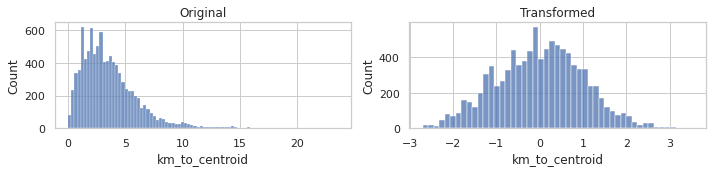

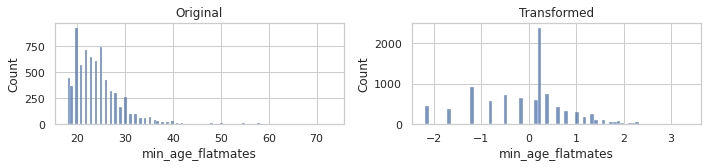

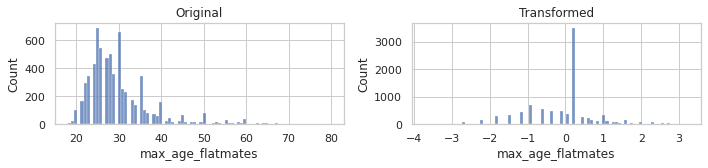

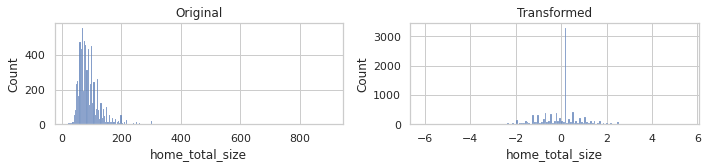

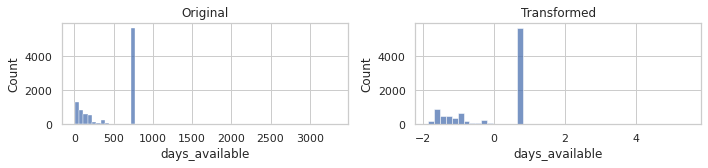

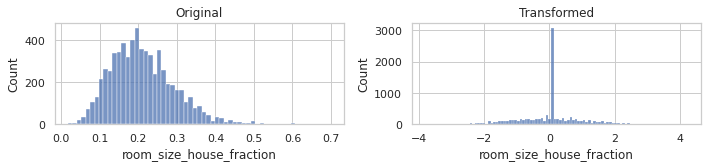

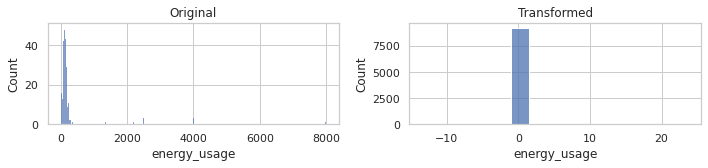

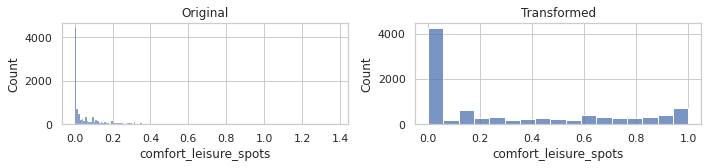

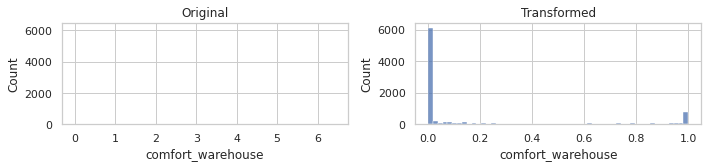

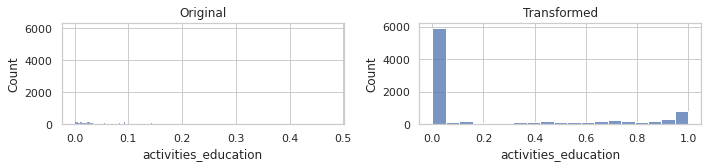

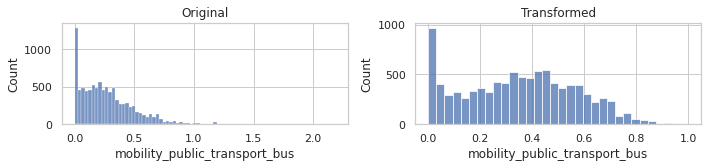

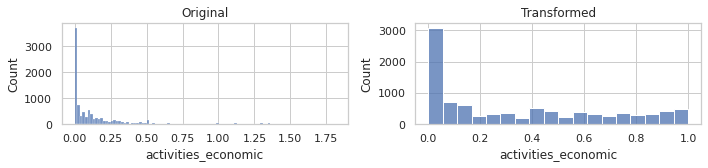

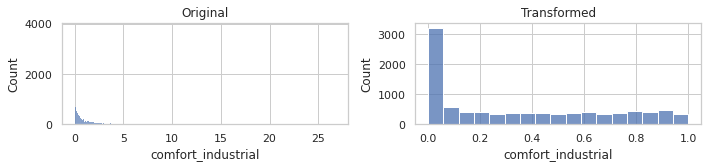

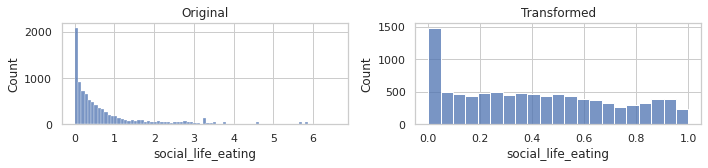

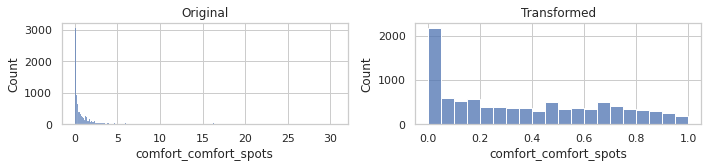

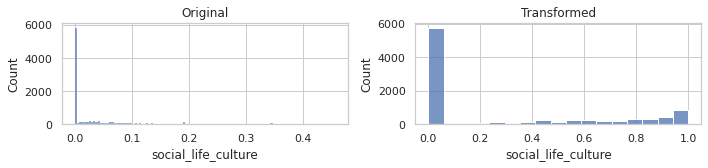

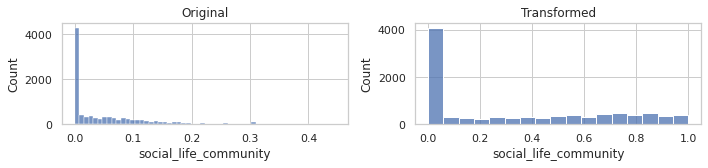

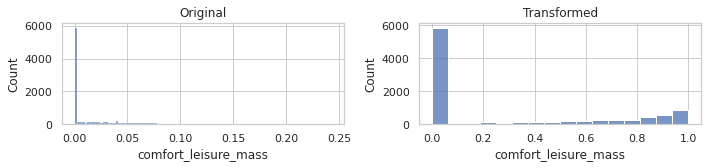

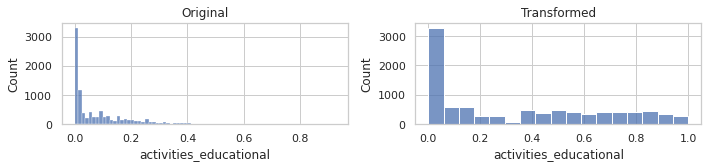

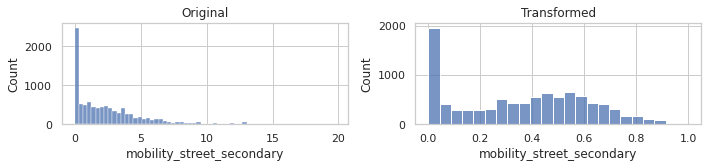

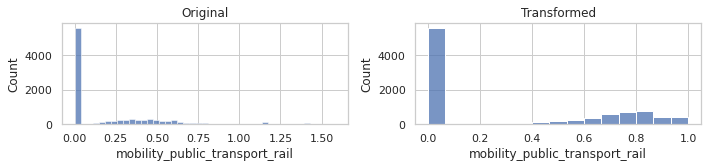

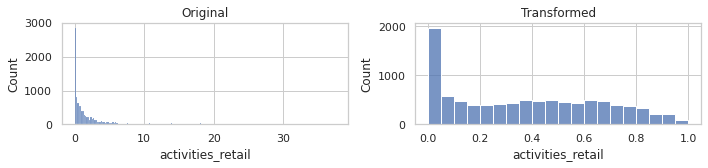

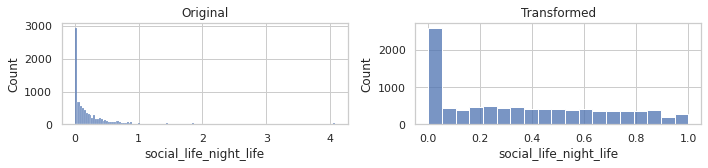

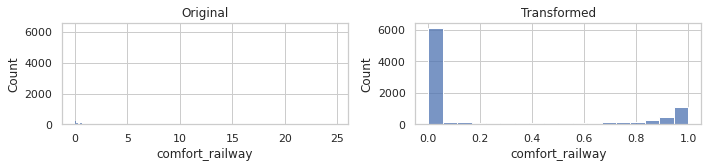

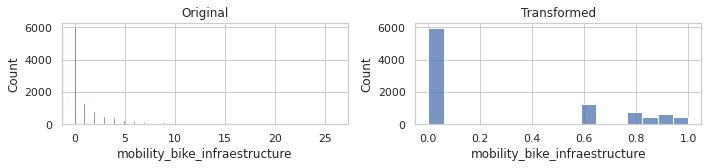

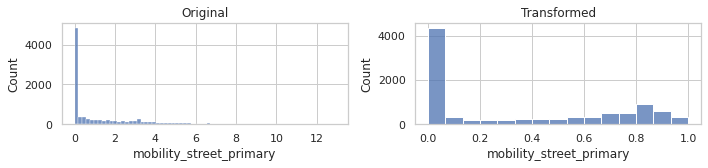

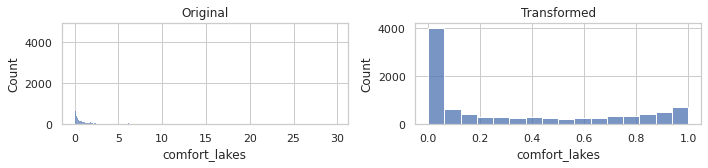

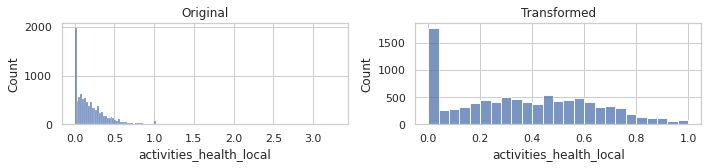

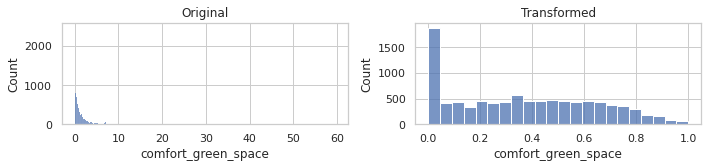

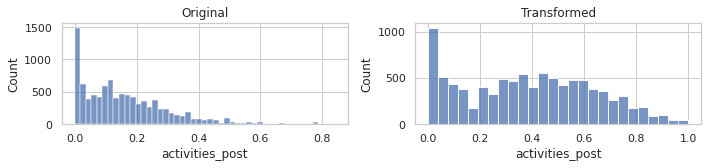

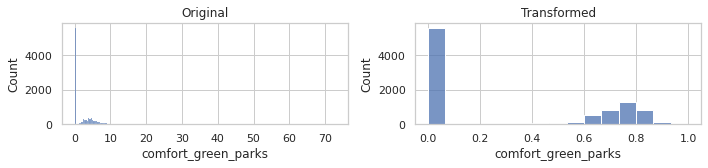

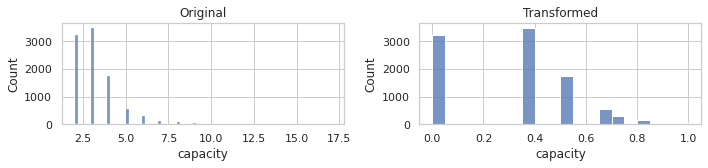

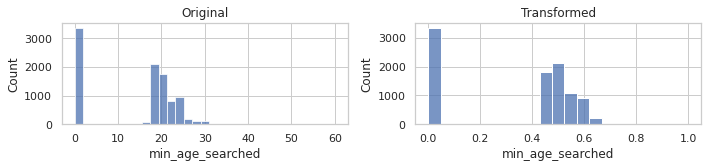

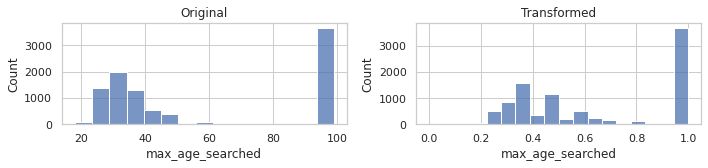

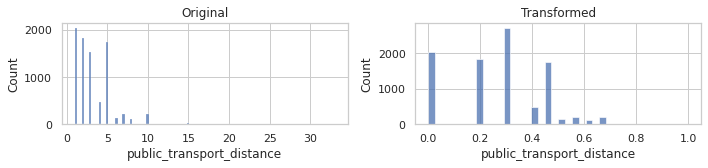

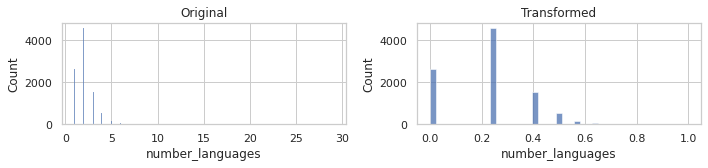

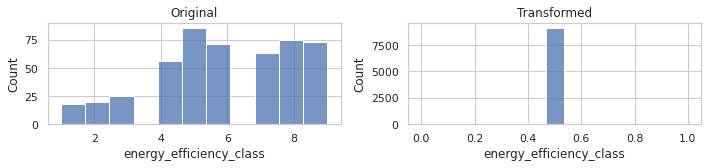

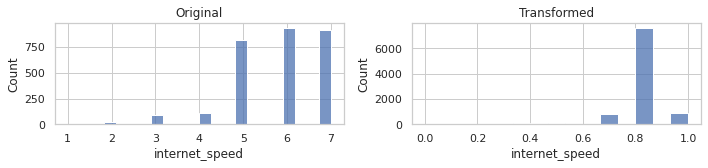

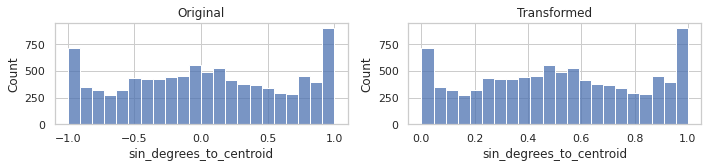

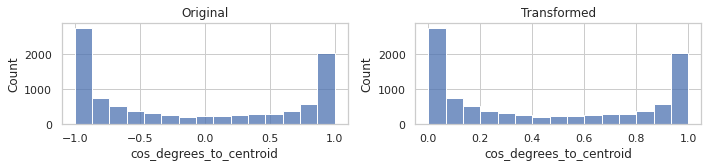

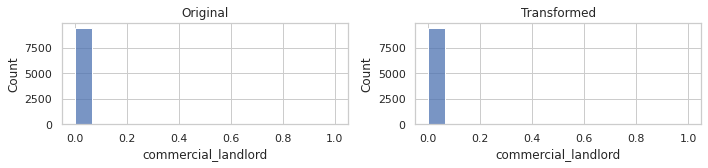

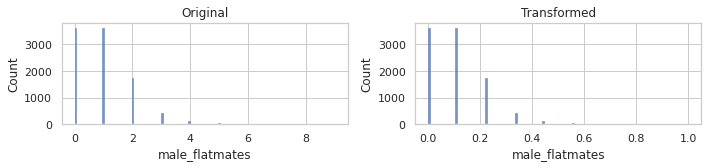

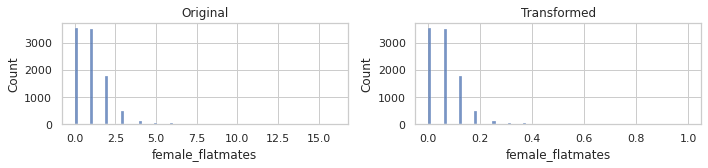

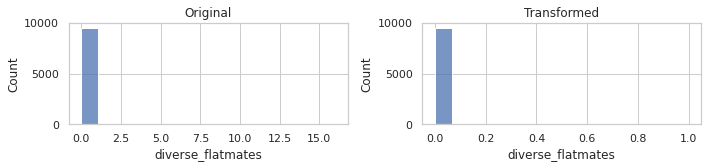

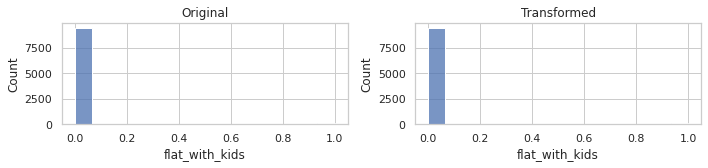

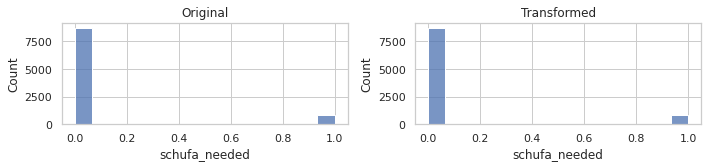

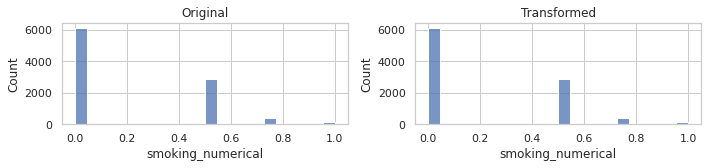

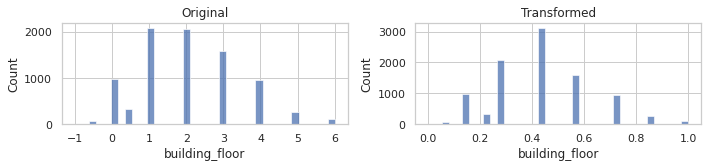

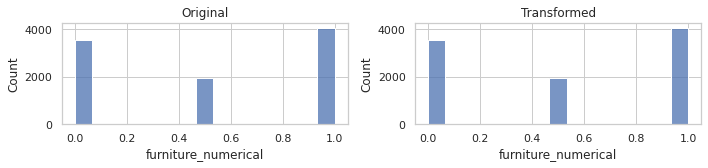

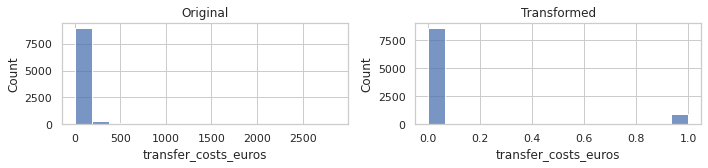

In [19]:
cols_ignore_plot = cols_SimpImpConstNoAns_OHE+features_already_OHE
for col_interest in [col for col in original_cols if col not in cols_ignore_plot]:
    sns.set_theme(style = "whitegrid", font_scale= 1)
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 2.5))

    sns.histplot(data=df_filtered.reset_index(drop=True), x = col_interest, kde=False, ax=ax1).set(title='Original')
    sns.histplot(data=df_processed.reset_index(drop=True), x = col_interest, kde=False, ax=ax2).set(title='Transformed')

    plt.tight_layout();

# Minimize features

In [20]:
# List of features to be ignored during analyis. See https://inmachineswetrust.com/posts/drop-first-columns/
features_ignore_analysis = cols_SimpImpConstNoAns_OHE + ['tv','shower_type','floor_type','extras','languages','wg_type']
features_ignore_analysis = [col+'_' for col in features_ignore_analysis]
features_ignore_analysis = [cols for cols in df_processed.columns if any(substring in cols for substring in features_ignore_analysis)]\
+ ['commercial_landlord','flat_with_kids','schufa_needed'] + ['internet_dsl','internet_wlan','internet_flatrate']
features_ignore_analysis

['tv_kabel',
 'tv_satellit',
 'shower_type_badewanne',
 'shower_type_dusche',
 'floor_type_dielen',
 'floor_type_parkett',
 'floor_type_laminat',
 'floor_type_teppich',
 'floor_type_fliesen',
 'floor_type_pvc',
 'floor_type_fußbodenheizung',
 'extras_waschmaschine',
 'extras_spuelmaschine',
 'extras_terrasse',
 'extras_balkon',
 'extras_garten',
 'extras_gartenmitbenutzung',
 'extras_keller',
 'extras_aufzug',
 'extras_haustiere',
 'extras_fahrradkeller',
 'extras_dachboden',
 'languages_deutsch',
 'languages_englisch',
 'wg_type_studenten',
 'wg_type_keine_zweck',
 'wg_type_maenner',
 'wg_type_business',
 'wg_type_wohnheim',
 'wg_type_vegetarisch_vegan',
 'wg_type_alleinerziehende',
 'wg_type_funktionale',
 'wg_type_berufstaetigen',
 'wg_type_gemischte',
 'wg_type_mit_kindern',
 'wg_type_verbindung',
 'wg_type_lgbtqia',
 'wg_type_senioren',
 'wg_type_inklusive',
 'wg_type_wg_neugruendung',
 'rental_length_term_180days',
 'rental_length_term_270days',
 'rental_length_term_30days',
 're

In [21]:
df_processed = pd.DataFrame(
                            preprocessor_transformer.fit_transform(df_filtered), 
                            columns=preprocessor_transformer.get_feature_names_out()
                            )

In [22]:
df_minimal = df_processed[[col for col in df_processed.columns if col not in features_ignore_analysis]]

In [23]:
# Define columns to be tested. Don't test the target, commercial_landlord and 'city'
cols_to_search = [col for col in df_minimal.columns if col not in [target]]
# cols_to_search = [col for col in cols_to_search if not col.startswith('city_')]

cols_exclude_minimization = []
for col in cols_to_search:
    # How many times the most frequent val exists
    most_freq_count = list(df_minimal[col].value_counts())[0]
    
    if most_freq_count > len(df_minimal)*0.95:
        cols_exclude_minimization.append(col)

        
# Exclude all columns (except cities) with >99% of the same value (0) as it contains very little information
df_minimal = df_minimal.drop(columns=cols_exclude_minimization)
df_minimal.shape

(9576, 44)

In [24]:
cols_exclude_minimization

['energy_usage', 'energy_efficiency_class', 'diverse_flatmates']

# Colinearity

In [25]:
df_VIF = df_minimal.copy()

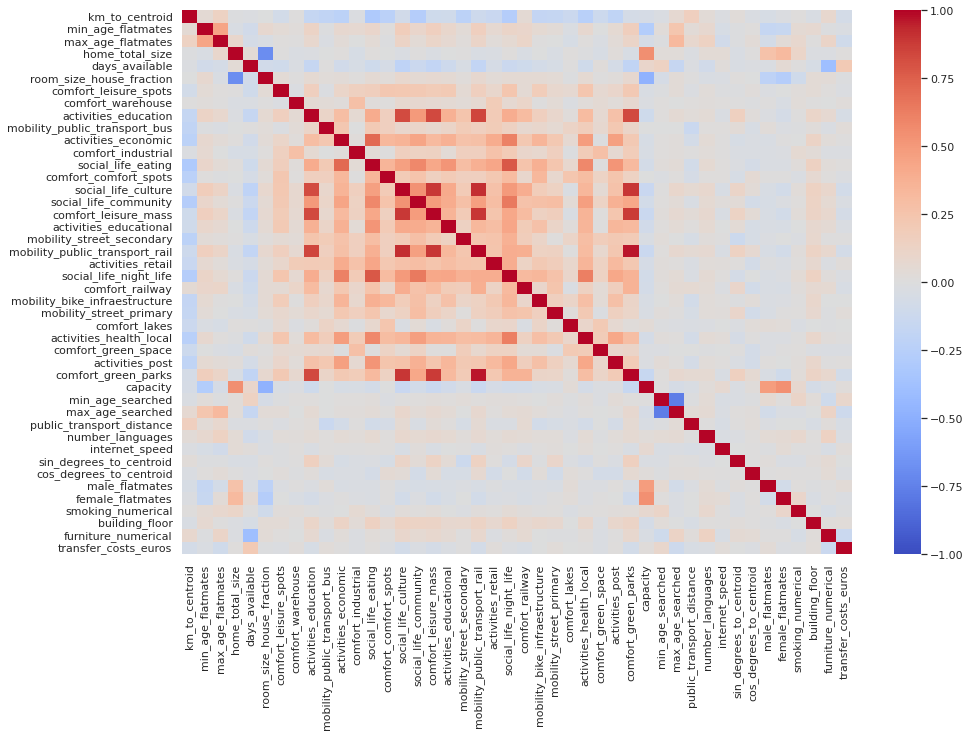

In [26]:
sns.set_theme(style = "whitegrid", font_scale= 1)
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))

data_corr = df_minimal.corr()
sns.heatmap(data_corr, cmap='coolwarm', 
            annot = False, 
            annot_kws={"size": 8},
            vmin=-1, vmax=1);

In [27]:
cols_to_exclude_VIF = [#'mobility_public_transport_rail',
#                         'parking_schlechte Parkmöglichkeiten',
#                         'rental_length_term_plus540days',
#                         'gender_searched_Egal',
#                         'internet_speed',
#                        'heating_no_answer',
#                         'max_age_searched',
#                         'days_available',
#                         'min_age_flatmates',
#                         'min_age_searched',
#                         #'age_category_searched_20_100',
#                         #'extras_gartenmitbenutzung',
                       ]

# df_analysed = df_analysed.drop(columns=cols_to_exclude_VIF)

In [28]:
# These are columns that are always removed, so I'm removing them prematurely to reduce the calculation time
df_VIF = df_VIF.drop(columns = cols_to_exclude_VIF)

In [29]:
data_corr = df_VIF.corr()

corr_df = data_corr.unstack().reset_index() # Unstack correlation matrix 
corr_df.columns = ['feature_1','feature_2', 'correlation'] # rename columns
# corr_df['correlation'] = -corr_df['correlation'] # Invert signal to see negative correlation
corr_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation
corr_df.head(30)

,feature_1,feature_2,correlation
865,mobility_public_transport_rail,comfort_green_parks,0.964097
1295,comfort_green_parks,mobility_public_transport_rail,0.964097
850,mobility_public_transport_rail,social_life_culture,0.914570
635,social_life_culture,mobility_public_transport_rail,0.914570
723,comfort_leisure_mass,mobility_public_transport_rail,0.894253
852,mobility_public_transport_rail,comfort_leisure_mass,0.894253
1290,comfort_green_parks,social_life_culture,0.893677
645,social_life_culture,comfort_green_parks,0.893677
632,social_life_culture,comfort_leisure_mass,0.884780
718,comfort_leisure_mass,social_life_culture,0.884780


In [30]:
# Automatized Variation Inflation Factor (VIF) analysis
# Removing columns must be done one at a time because they influence each others VIF results

remove = True
while remove:
    df = pd.DataFrame()
    
    selected_columns = [target] # Ignore the targer column
    selected_columns = [col for col in df_VIF.columns.to_list() if col not in selected_columns]

    df["features"] = selected_columns

    df["vif_index"] = [vif(df_VIF[selected_columns].values, i) for i in range(df_VIF[selected_columns].shape[1])]

    df = round(df.sort_values(by="vif_index", ascending = False),2)
    
    df = df.head(1)

    if float(df.vif_index) >= 10:
        print(df)
        cols_to_exclude_VIF = cols_to_exclude_VIF + df.features.to_list()
        df_VIF = df_VIF.drop(columns = df.features)
    else:
        remove = False

cols_to_exclude_VIF

                          features  vif_index
19  mobility_public_transport_rail      39.16
          features  vif_index
34  internet_speed      33.56
               features  vif_index
28  comfort_green_parks      13.57
              features  vif_index
12  social_life_eating      11.83
               features  vif_index
13  social_life_culture      10.13


['mobility_public_transport_rail',
 'internet_speed',
 'comfort_green_parks',
 'social_life_eating',
 'social_life_culture']

In [31]:
# Variation Inflation Factor (VIF) analysis
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
df = pd.DataFrame()


selected_columns = [col for col in df_VIF.columns.to_list() if col not in [target]]

df["features"] = selected_columns

df["vif_index"] = [vif(df_VIF[selected_columns].values, i) for i in range(df_VIF[selected_columns].shape[1])]

round(df.sort_values(by="vif_index", ascending = False),2)[:10]

,features,vif_index
28,max_age_searched,9.41
26,capacity,7.45
18,social_life_night_life,6.83
36,building_floor,5.85
14,comfort_leisure_mass,5.72
8,activities_education,5.46
23,activities_health_local,5.44
25,activities_post,4.90
27,min_age_searched,4.65
10,activities_economic,4.18


In [32]:
df_VIF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9576 entries, 0 to 9575
Data columns (total 39 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   km_to_centroid                 9576 non-null   float64
 1   min_age_flatmates              9576 non-null   float64
 2   max_age_flatmates              9576 non-null   float64
 3   home_total_size                9576 non-null   float64
 4   days_available                 9576 non-null   float64
 5   room_size_house_fraction       9576 non-null   float64
 6   comfort_leisure_spots          9576 non-null   float64
 7   comfort_warehouse              9576 non-null   float64
 8   activities_education           9576 non-null   float64
 9   mobility_public_transport_bus  9576 non-null   float64
 10  activities_economic            9576 non-null   float64
 11  comfort_industrial             9576 non-null   float64
 12  comfort_comfort_spots          9576 non-null   f

# Feature permutation

In [33]:
df_permuted = df_VIF.copy()

## Permutation analysis

In [34]:
X = df_permuted
y = df_filtered[target]

model = Ridge().fit(X, y) # Fit model

permutation_score = permutation_importance(model, X, y,
                                           scoring = ['r2','neg_root_mean_squared_error'],
                                           n_repeats=100, n_jobs=-1) # Perform Permutation

In [35]:
importance_df = pd.DataFrame(np.vstack((X.columns,
                                        permutation_score['r2'].importances_mean,
                                       permutation_score['r2'].importances_std,
                                        permutation_score['neg_root_mean_squared_error'].importances_mean,
                                       permutation_score['neg_root_mean_squared_error'].importances_std)).T) # Unstack results

importance_df.columns=['feature',
                       'r2 score decrease','r2 score decrease std',
                       'RMSE score increase','RMSE score increase std']

In [36]:
importance_df = importance_df.sort_values(by="r2 score decrease", ascending = False) # Order by importance
importance_df[:50]

,feature,r2 score decrease,r2 score decrease std,RMSE score increase,RMSE score increase std
5,room_size_house_fraction,0.644514,0.009997,3.008206,0.04031
3,home_total_size,0.304938,0.007353,1.541134,0.034202
0,km_to_centroid,0.021379,0.001635,0.117492,0.008919
4,days_available,0.020751,0.001958,0.114063,0.01069
37,furniture_numerical,0.018545,0.001623,0.102014,0.008876
14,comfort_leisure_mass,0.017906,0.001531,0.098518,0.008372
20,mobility_bike_infraestructure,0.017767,0.001694,0.097759,0.009265
15,activities_educational,0.016681,0.00168,0.091816,0.009198
26,capacity,0.016675,0.001641,0.091784,0.008985
19,comfort_railway,0.014552,0.001531,0.080153,0.008391


In [37]:
top_features = []
scores = []

for features in range(1, len(importance_df)): # Loop over the total number of features
    
    most_important_features = list(importance_df.head(features).feature) # List the name of the features in specific loop
   
    X_reduced = X[most_important_features] # Make feature set with the selected features
    
    cv_results = cross_val_score(model, X_reduced, y, cv=10) # cross validate
    
    scores.append(cv_results.mean()) # Append scores
    
    top_features.append(features)  # Append number of features

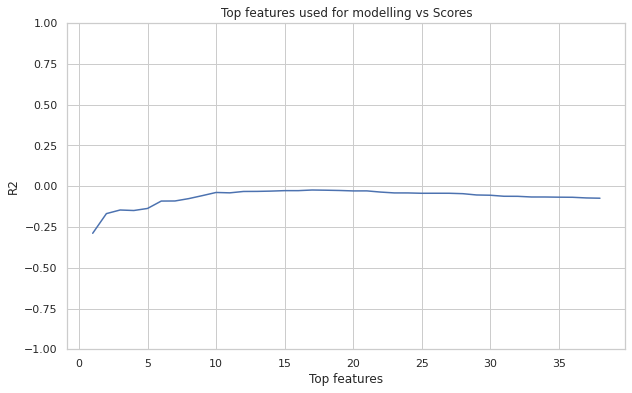

In [38]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(top_features, scores)
plt.title('Top features used for modelling vs Scores')
# plt.xlim([0,100])
plt.ylim([-1,1])
plt.xlabel('Top features')
plt.ylabel('R2');

In [39]:
importance_df_selected = importance_df[importance_df['r2 score decrease']>= 0.001]
columns_excluded_permutation = importance_df[importance_df['r2 score decrease']< 0.001]
# max_score_n_features = scores.index(max(scores))
# importance_df_selected = importance_df.head(max_score_n_features)
print(importance_df_selected.shape)
importance_df_selected

(26, 5)


,feature,r2 score decrease,r2 score decrease std,RMSE score increase,RMSE score increase std
5,room_size_house_fraction,0.644514,0.009997,3.008206,0.04031
3,home_total_size,0.304938,0.007353,1.541134,0.034202
0,km_to_centroid,0.021379,0.001635,0.117492,0.008919
4,days_available,0.020751,0.001958,0.114063,0.01069
37,furniture_numerical,0.018545,0.001623,0.102014,0.008876
14,comfort_leisure_mass,0.017906,0.001531,0.098518,0.008372
20,mobility_bike_infraestructure,0.017767,0.001694,0.097759,0.009265
15,activities_educational,0.016681,0.00168,0.091816,0.009198
26,capacity,0.016675,0.001641,0.091784,0.008985
19,comfort_railway,0.014552,0.001531,0.080153,0.008391


In [40]:
important_features = importance_df_selected.feature.to_list()

In [41]:
columns_excluded_permutation = columns_excluded_permutation.feature.to_list()
columns_excluded_permutation

['social_life_night_life',
 'activities_education',
 'mobility_public_transport_bus',
 'activities_health_local',
 'social_life_community',
 'min_age_searched',
 'comfort_lakes',
 'public_transport_distance',
 'building_floor',
 'number_languages',
 'activities_retail',
 'comfort_warehouse',
 'max_age_flatmates']

# Predictive Power Score

In [42]:
# ppscore 1.2.0 requires scikit-learn<1.0.0,>=0.20.2, but I have scikit-learn 1.1.2 which is incompatible.

In [43]:
# A correlation analysis that detects assimetric, also non-linear and numeric plus categorical relationships
# assimetric: ZIP predicts city but the city is a poor predictor of ZIP code
# also non-linear: uses Decision Tree to find relationships that might be linear or not
# numeric plus categorical: finds relationships also in categorical features
# https://towardsdatascience.com/rip-correlation-introducing-the-predictive-power-score-3d90808b9598

In [44]:
# pps_matrix = pps.matrix(df_analysed[important_features])

In [45]:
# sns.set_theme(style = "whitegrid", font_scale= 1)
# fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(25, 35))

# matrix_df = pps_matrix[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
# sns.heatmap(matrix_df, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=False, annot_kws={"size": 8});

# Create new processing pipeline after analysis

In [46]:
columns_to_remove = sorted(cols_exclude_minimization + cols_to_exclude_VIF + columns_excluded_permutation)
columns_to_remove

['activities_education',
 'activities_health_local',
 'activities_retail',
 'building_floor',
 'comfort_green_parks',
 'comfort_lakes',
 'comfort_warehouse',
 'diverse_flatmates',
 'energy_efficiency_class',
 'energy_usage',
 'internet_speed',
 'max_age_flatmates',
 'min_age_searched',
 'mobility_public_transport_bus',
 'mobility_public_transport_rail',
 'number_languages',
 'public_transport_distance',
 'social_life_community',
 'social_life_culture',
 'social_life_eating',
 'social_life_night_life']

In [47]:
preprocessor_analysed = ColumnTransformer([
    ('pipeline-1', PowerTrans_SimpImpMean, [col for col in cols_PowerTrans_SimpImpMean if col not in columns_to_remove]),
    ('pipeline-2', PowerTrans_SimpImpMedian_MinMaxScaler, [col for col in cols_PowerTrans_SimpImpMedian_MinMaxScaler if col not in columns_to_remove]),
    ('pipeline-3', SimpImpMean_MinMaxScaler, [col for col in cols_SimpImpMean_MinMaxScaler if col not in columns_to_remove]),
    ('pipeline-4', SimpImpMedian_MinMaxScaler, [col for col in cols_SimpImpMedian_MinMaxScaler if col not in columns_to_remove]),
    ('pipeline-5', SimpImpConst0_PowerTrans_MinMaxScaler, [col for col in cols_SimpImpConst0_PowerTrans_MinMaxScaler if col not in columns_to_remove]),
    ('pipeline-6', SimpImpConstNoAns_OHE, [col for col in cols_SimpImpConstNoAns_OHE if col not in columns_to_remove])
     ],
    remainder='drop',
    verbose_feature_names_out=False)
preprocessor_analysed

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('SimpleImputer',
                                                  SimpleImputer()),
                                                 ('PowerTransformer',
                                                  PowerTransformer())]),
                                 ['km_to_centroid', 'min_age_flatmates',
                                  'home_total_size', 'days_available',
                                  'room_size_house_fraction']),
                                ('pipeline-2',
                                 Pipeline(steps=[('SimpleImputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('PowerTransformer',
                                                  PowerTran...
                                                  PowerTransformer()),
                                                 ('MinMaxScaler',
                                                  MinMaxScaler())]),
                                 ['transfer_costs_euros']),
                                ('pipeline-6',
                                 Pipeline(steps=[('SimpleImputer',
                                                  SimpleImputer(fill_value='no_answer',
                                                                strategy='constant')),
                                                 ('OHE',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse=False))]),
                                 ['rental_length_term', 'gender_searched',
                                  'building_type', 'heating', 'parking',
                                  'city'])],
                  verbose_feature_names_out=False)

#  Model hyper-parametrization with GridSearchCV

In [48]:
# Get transformed table with corresponding column names
X = pd.DataFrame(
                preprocessor_analysed.fit_transform(df_filtered), 
                columns=preprocessor_analysed.get_feature_names_out()
                )

y = df_filtered[target]


In [49]:
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

## Neuron Network model

In [50]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.constraints import MaxNorm
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

2022-09-14 20:35:40.600003: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-14 20:35:40.695003: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-14 20:35:40.698870: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-14 20:35:40.698887: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [51]:
def plot_history(history):
    plt.plot(history.history['loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()

def plot_loss_accuracy(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()
    
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('Model MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()

In [52]:
def create_NN_model(X_train, y_train,
                    input_dim = None,
                    fitting = False,
                    n_neurons_layer1 = 32,
                    n_neurons_layer2 = 0,
                    n_neurons_layer3 = 0,
                    activation_layer1 = 'sigmoid',#['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
                    activation_layer2 = 'tanh',
                    activation_layer3 = 'relu',
                    learning_rate=0.01, beta_1=0.9, beta_2=0.999,
                    loss='mse',
                    metrics=['mae','msle'],
                    patience=10,
                    batch_size=32, epochs=150,
                    init_mode='normal',#['glorot_normal', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
                    dropout_rate=0.2,
                    weight_constraint=1.0 #[1.0, 2.0, 3.0, 4.0, 5.0]
                   ):
    
    if input_dim is None:
        input_dim = len(X_train.columns)
    
    #### 1. ARCHITECTURE
    model = Sequential()
    
    model.add(Dense(n_neurons_layer1, input_shape=(input_dim,), activation=activation_layer1))
    model.add(Dropout(dropout_rate))   # Dropout helps protect the model from memorizing or "overfitting" the training data
    if n_neurons_layer2>0:
        model.add(Dense(n_neurons_layer2, activation=activation_layer2))
        model.add(Dropout(dropout_rate))
    if n_neurons_layer3>0:
        model.add(Dense(n_neurons_layer3, activation=activation_layer3))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='linear', kernel_initializer=init_mode))
    
    #### 2. COMPILATION
    adam_opt = Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2)
    model.compile(loss=loss, 
              optimizer=adam_opt,
              metrics=metrics)
    
    #### 3. FIT
    if fitting:
        es = EarlyStopping(patience=patience, restore_best_weights=True)

        # Don't set the fit method so the model can be used in GridSearchCV
        history = model.fit(X_train, y_train,
                            validation_split=0.3,
                            shuffle=True,
                            batch_size=batch_size, # When batch size is too small --> no generalization
                            epochs=epochs,    # When batch size is too large --> slow computations
                            callbacks=[es],
                            verbose=0
                           )

        plot_loss_accuracy(history)

    return model

### Test NeuralNetwork

2022-09-14 20:35:41.808060: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-14 20:35:41.808095: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-14 20:35:41.808111: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Carlos): /proc/driver/nvidia/version does not exist
2022-09-14 20:35:41.808333: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


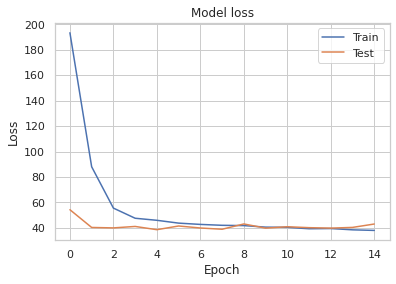

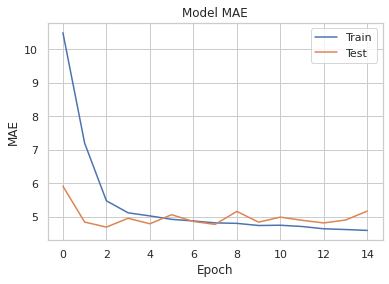

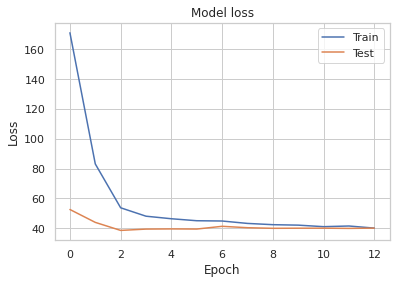

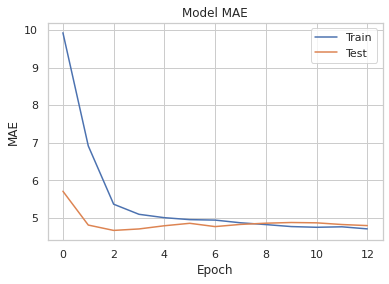

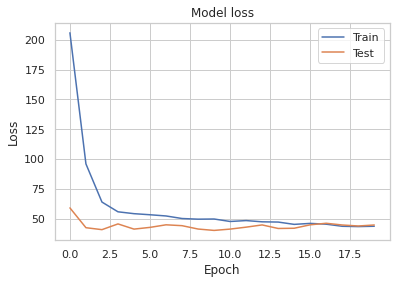

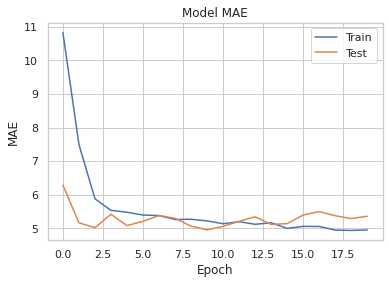

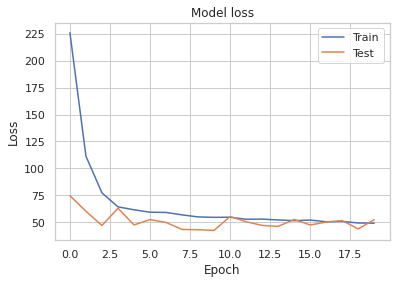

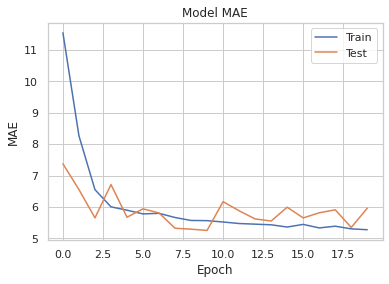

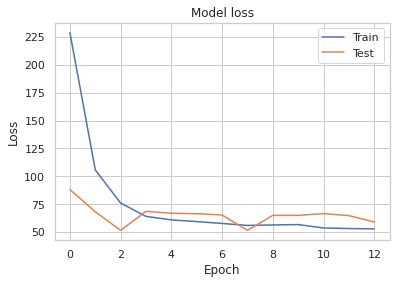

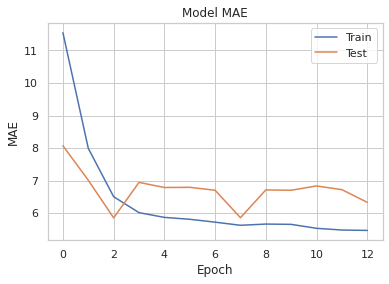

In [54]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
kf = KFold(n_splits=5)
kf.get_n_splits(X)
NeuralNetwork_models = []
for train_index, test_index in kf.split(X):
    
    # Split the data into train and test
    X_train, X_test = np.array(X)[train_index], np.array(X)[test_index]
    y_train, y_test = np.array(y)[train_index], np.array(y)[test_index]

    NeuralNetwork_models.append(create_NN_model(X_train=X_train, y_train=y_train, input_dim =X_train.shape[1], fitting = True))
#     NeuralNetwork_rsearch.summary()

In [55]:
summary_results = pd.DataFrame({'KFold1':NeuralNetwork_models[0].evaluate(X_test, y_test,verbose=0),
            'KFold2':NeuralNetwork_models[1].evaluate(X_test, y_test,verbose=0),
            'KFold3':NeuralNetwork_models[2].evaluate(X_test, y_test,verbose=0),
            'KFold4':NeuralNetwork_models[3].evaluate(X_test, y_test,verbose=0),
            'KFold5':NeuralNetwork_models[4].evaluate(X_test, y_test,verbose=0)},
                               index = ['loss','MAE','MSLE'])
summary_results['average'] = summary_results.mean(axis=1)
summary_results['std'] = summary_results.std(axis=1)
summary_results.round(3)

,KFold1,KFold2,KFold3,KFold4,KFold5,average,std
loss,35.406,34.117,37.398,43.429,44.629,38.996,4.258
MAE,4.709,4.500,4.866,5.313,5.474,4.973,0.367
MSLE,0.075,0.070,0.079,0.090,0.095,0.082,0.009


### GridSearchCV NeuralNetwork

In [56]:
if True:
    # Clear memory
    tf.keras.backend.clear_session()

    # Instanciate model
    NeuralNetwork = KerasRegressor(model=create_NN_model(X_train=X, y_train=y, fitting = False), verbose=0)

    # fix random seed for reproducibility
    tf.random.set_seed(42)


    # Hyperparameter search space
    search_space = {
                    'epochs': [50],#[50, 100, 150],
                    'batch_size': [32],
#                     'model__n_neurons_layer1': [16,32,64],
#                     'model__n_neurons_layer2': [0],#[16,32,64],
                    # 'model__n_neurons_layer3': [0],#[16,32,64],
#                     'model__activation_layer1': ['sigmoid'],#['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'],
                    # 'model__activation_layer2': ['relu'],#['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'],
                    # 'model__activation_layer3': ['relu'],#['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'],
#                     'model__dropout_rate': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
                    # 'model__weight_constraint': [3.0],#[1.0, 2.0, 3.0, 4.0, 5.0],
                    # 'model__init_mode': ['normal'],#['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
#                     'optimizer__learning_rate': [0.01],
                #     'optimizer__beta_1': [0.9],
                #     'optimizer__beta_2': [0.999],
                #     'loss': ['mse'],
#                     'validation_split': [0.1,0.3,0.5],
#                     'shuffle':[True,False],
                }

    # Instanciate GridSearchCV
    NeuralNetwork_rsearch = GridSearchCV(
        NeuralNetwork, search_space,
        cv=3, verbose=0)


    NeuralNetwork_rsearch.fit(X,y)

    # summarize results
    report_best_scores(NeuralNetwork_rsearch.cv_results_, 1)

INFO:tensorflow:Assets written to: ram:///tmp/tmpcr9lskmx/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpx6b432_l/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpzx1uugvx/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmph8v831k0/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpjs4vkui2/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpv2596sur/assets
Model with rank: 1
Mean validation score: 0.015 (std: 0.139)
Parameters: {'batch_size': 256, 'epochs': 50, 'optimizer__learning_rate': 0.01}



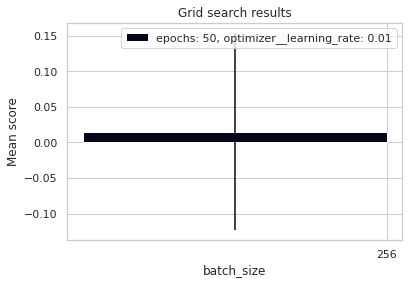

In [57]:
if True:
    plot.grid_search(NeuralNetwork_rsearch.cv_results_, change="batch_size", kind='bar')
    plt.legend(bbox_to_anchor=(1, 1));

## Ridge linear Regression

In [58]:
%%time
# Instanciate model
model = Ridge()

# Hyperparameter search space
search_space = {
    'alpha': [1,10,100,1000],
    'tol': [0, 0.001,0.1,1],
    'solver': ['lsqr','auto']# auto, 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs']
}

# Instanciate GridSearchCV
ridge_rsearch = GridSearchCV(
    model, search_space,
    n_jobs=-1, scoring='neg_root_mean_squared_error', cv=5, verbose=0)


ridge_rsearch.fit(X,y)
report_best_scores(ridge_rsearch.cv_results_, 1)

Model with rank: 1
Mean validation score: -7.380 (std: 1.075)
Parameters: {'alpha': 100, 'solver': 'auto', 'tol': 0}

Model with rank: 1
Mean validation score: -7.380 (std: 1.075)
Parameters: {'alpha': 100, 'solver': 'auto', 'tol': 0.001}

Model with rank: 1
Mean validation score: -7.380 (std: 1.075)
Parameters: {'alpha': 100, 'solver': 'auto', 'tol': 0.1}

Model with rank: 1
Mean validation score: -7.380 (std: 1.075)
Parameters: {'alpha': 100, 'solver': 'auto', 'tol': 1}

CPU times: user 531 ms, sys: 247 ms, total: 778 ms
Wall time: 2.83 s


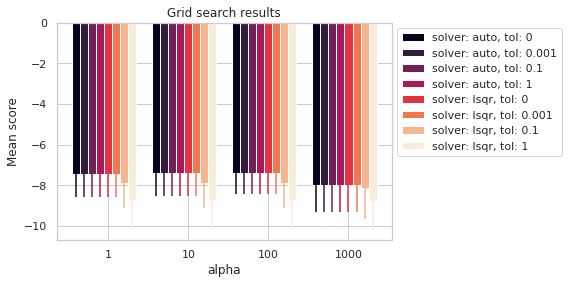

In [59]:
plot.grid_search(ridge_rsearch.cv_results_, change="alpha", kind='bar')
plt.legend(bbox_to_anchor=(1, 1));

## Lasso linear Regression

In [60]:
%%time
# Instanciate model
model = Lasso()

# Hyperparameter search space
search_space = {
    'alpha': [0.001,0.01,0.1,1],
    'tol': [0.1,1,10,100],
    'selection': ['cyclic', 'random']
}

# Instanciate GridSearchCV
lasso_rsearch = GridSearchCV(
    model, search_space,
    n_jobs=-1, scoring='neg_root_mean_squared_error', cv=5, verbose=0)


lasso_rsearch.fit(X,y)
report_best_scores(lasso_rsearch.cv_results_, 1)

Model with rank: 1
Mean validation score: -7.463 (std: 0.986)
Parameters: {'alpha': 0.01, 'selection': 'cyclic', 'tol': 0.1}

CPU times: user 607 ms, sys: 175 ms, total: 782 ms
Wall time: 2.25 s


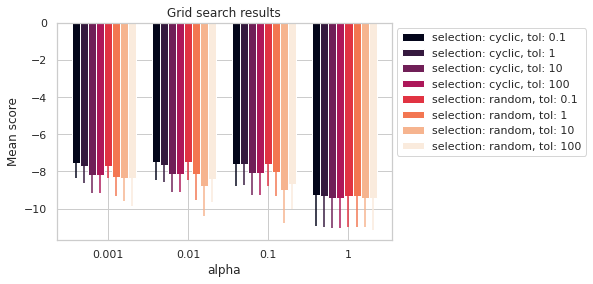

In [61]:
plot.grid_search(lasso_rsearch.cv_results_, change="alpha", kind='bar')
plt.legend(bbox_to_anchor=(1, 1));

## ElasticNet linear Regression

In [62]:
%%time
# Instanciate model
model = ElasticNet()

# Hyperparameter search space
search_space = {
    'alpha': [0.001,0.01,0.1,1],
    'tol': [1,10,100],
    'l1_ratio': [0,0.3,0.6,1],
    'selection': ['cyclic', 'random']
}

# Instanciate GridSearchCV
elastic_rsearch = GridSearchCV(
    model, search_space,
    n_jobs=-1, scoring='neg_root_mean_squared_error', cv=5, verbose=0)


elastic_rsearch.fit(X,y)
report_best_scores(elastic_rsearch.cv_results_, 1)

Model with rank: 1
Mean validation score: -7.591 (std: 1.013)
Parameters: {'alpha': 0.01, 'l1_ratio': 0, 'selection': 'cyclic', 'tol': 1}

CPU times: user 1.84 s, sys: 286 ms, total: 2.13 s
Wall time: 5.27 s


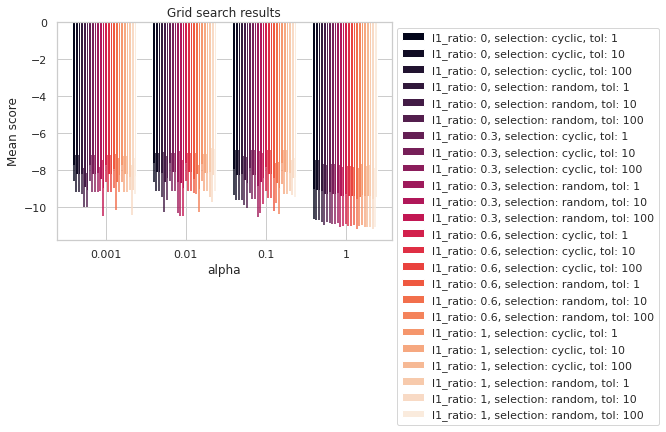

In [63]:
plot.grid_search(elastic_rsearch.cv_results_, change="alpha", kind='bar')
plt.legend(bbox_to_anchor=(1, 1));

## Stochastic Gradient Descend

In [64]:
%%time
# Instanciate model
model = SGDRegressor()

# Hyperparameter search space
search_space = {
    'loss':['squared_error','epsilon_insensitive', 'squared_epsilon_insensitive'],#, 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    'alpha': [0.0001, 0.001,0.01],
    'penalty': ['elasticnet'],#['l1','l2','elasticnet'],
    'tol': [10],#[1,10,100],
    'l1_ratio': [1],#[0,0.3,0.6,1],
    'epsilon': [1,10,100],
    'learning_rate': ['invscaling'],#,'constant','optimal','adaptive'],
    'eta0': [0.001,0.01,0.1], 
    'power_t': [0.25],
    'early_stopping': [True]
}

# Instanciate GridSearchCV
sgdr_rsearch = GridSearchCV(
    model, search_space,
    n_jobs=-1, scoring='neg_root_mean_squared_error', cv=5, verbose=0)


sgdr_rsearch.fit(X,y)
report_best_scores(sgdr_rsearch.cv_results_, 1)

Model with rank: 1
Mean validation score: -7.322 (std: 1.229)
Parameters: {'alpha': 0.0001, 'early_stopping': True, 'epsilon': 1, 'eta0': 0.01, 'l1_ratio': 1, 'learning_rate': 'invscaling', 'loss': 'squared_epsilon_insensitive', 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 10}

CPU times: user 994 ms, sys: 411 ms, total: 1.4 s
Wall time: 5.8 s


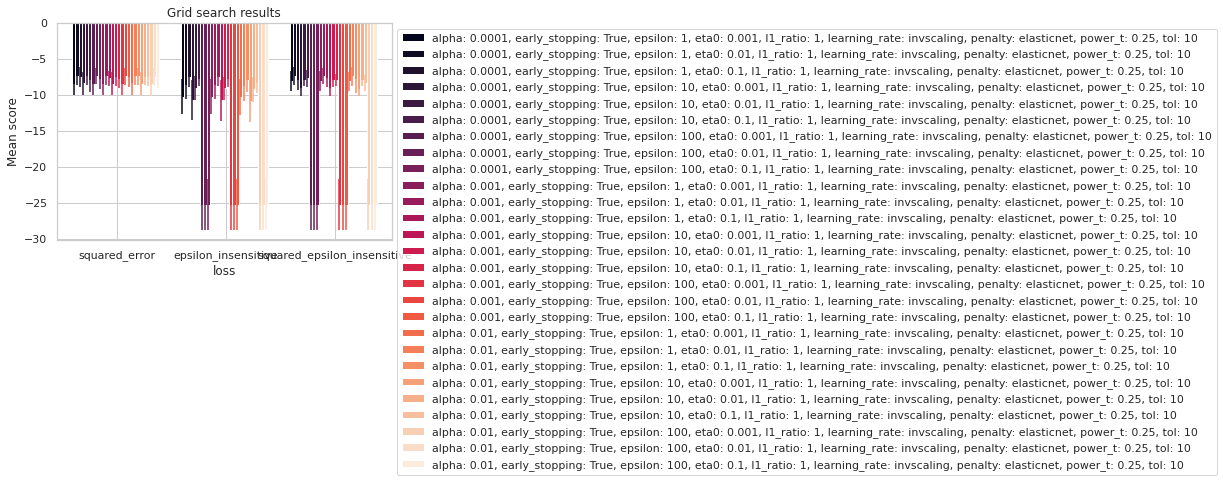

In [65]:
plot.grid_search(sgdr_rsearch.cv_results_, change="loss", kind='bar')
plt.legend(bbox_to_anchor=(1, 1));

## KNN Regressor

In [66]:
%%time
# Instanciate model
model = KNeighborsRegressor(n_jobs=-1)

# Hyperparameter search space
search_space = {
    'n_neighbors': range(30,50,1),
    'weights': ['distance'],#['uniform', 'distance'],
    'algorithm': ['brute'],#['ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [2]#range(2,15,1)
}

# Instanciate GridSearchCV
knn_rsearch = GridSearchCV(
    model, search_space,
    n_jobs=-1, scoring='neg_root_mean_squared_error', cv=5, verbose=0)


knn_rsearch.fit(X,y)
report_best_scores(knn_rsearch.cv_results_, 1)

Model with rank: 1
Mean validation score: -8.689 (std: 1.605)
Parameters: {'algorithm': 'brute', 'leaf_size': 2, 'n_neighbors': 34, 'weights': 'distance'}

CPU times: user 559 ms, sys: 52.2 ms, total: 612 ms
Wall time: 31.5 s


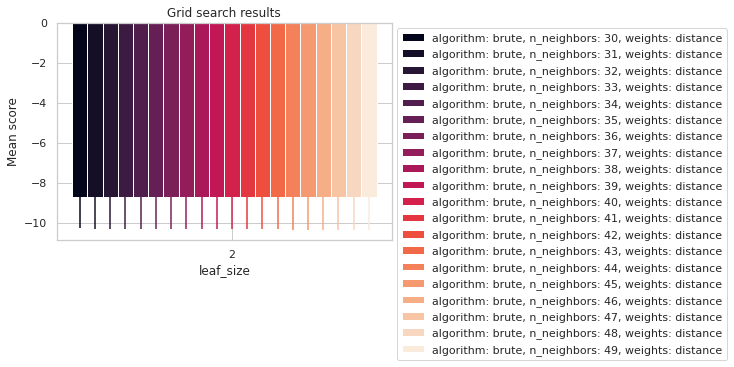

In [67]:
plot.grid_search(knn_rsearch.cv_results_, change="leaf_size", kind='bar')
plt.legend(bbox_to_anchor=(1, 1));

## Support Vector Machine

In [68]:
%%time
# Instanciate model
model = SVR()

# Hyperparameter search space
search_space = {
    'kernel': ['poly'],#['linear','poly','sigmoid', 'rbf'],
    'degree': range(2,5,1),
    'C': [10,100,1000],
    'tol': [0.001],#[0.001,0.01,0.1],
    'gamma': ['auto'],#[0,0.1,1,'scale','auto'],
    'coef0': [0],#[0,0.1,1],
    'epsilon': [1],#[0.1,1,10]
}

# Instanciate GridSearchCV
svm_rsearch = GridSearchCV(
    model, search_space,
    n_jobs=-1, scoring='neg_root_mean_squared_error', cv=5, verbose=0)


svm_rsearch.fit(X,y)
report_best_scores(svm_rsearch.cv_results_, 1)

Model with rank: 1
Mean validation score: -7.460 (std: 1.287)
Parameters: {'C': 100, 'coef0': 0, 'degree': 2, 'epsilon': 1, 'gamma': 'auto', 'kernel': 'poly', 'tol': 0.001}

CPU times: user 4.27 s, sys: 0 ns, total: 4.27 s
Wall time: 1min 43s


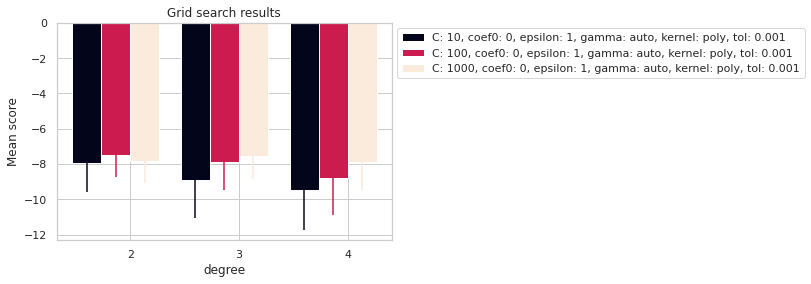

In [69]:
plot.grid_search(svm_rsearch.cv_results_, change="degree", kind='bar')
plt.legend(bbox_to_anchor=(1, 1));

## Decision Tree Regressor

In [70]:
%%time
# Instanciate model
model = DecisionTreeRegressor()

# Hyperparameter search space
search_space = {
    'criterion': ['squared_error'],#['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'splitter': ['best','random'],
    'max_depth': range(2,5,1),
    'min_samples_split': range(14,17,1),
    'min_samples_leaf': range(2,5,1),
    'min_weight_fraction_leaf': [0.0],#[0.0,0.1,0.2],
    'max_features': [0.8],#[0.6,0.7,0.8,0.9],
    'max_leaf_nodes': [4],#range(3,5,1), #int, default=None
    'min_impurity_decrease': [0.3],#[0.2,0.3,0.4,0.5],
    'ccp_alpha':[0.0],#[0.2,0.25,0.3,0.35],
}

# Instanciate GridSearchCV
tree_rsearch = GridSearchCV(
    model, search_space,
    n_jobs=-1, scoring='neg_root_mean_squared_error', cv=5, verbose=0)


tree_rsearch.fit(X,y)
report_best_scores(tree_rsearch.cv_results_, 1)

Model with rank: 1
Mean validation score: -8.424 (std: 1.377)
Parameters: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 3, 'max_features': 0.8, 'max_leaf_nodes': 4, 'min_impurity_decrease': 0.3, 'min_samples_leaf': 3, 'min_samples_split': 16, 'min_weight_fraction_leaf': 0.0, 'splitter': 'random'}

CPU times: user 471 ms, sys: 0 ns, total: 471 ms
Wall time: 2.46 s


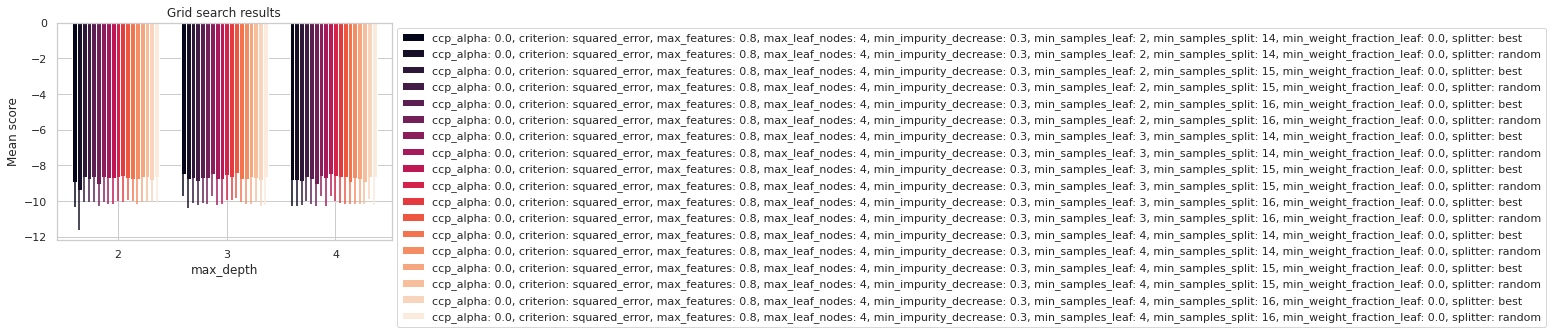

In [71]:
plot.grid_search(tree_rsearch.cv_results_, change="max_depth", kind='bar')
plt.legend(bbox_to_anchor=(1, 1));

## Random Forest Regressor

In [72]:
%%time
# Instanciate model
model = RandomForestRegressor()

# Hyperparameter search space
search_space = {
    'n_jobs':[-1],
    'n_estimators': [100],#[100,200,500,1000],
    'criterion': ['squared_error'],#['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'max_depth': range(5,20,5),
    'min_samples_split': [4],#range(3,6,1),
    'min_samples_leaf': [3],#range(2,4,1),
    'min_weight_fraction_leaf': [0.0],#[0.0,0.1,0.2],
    'max_features': [1.0],#[0.7,0.8,0.9,1.0],
    'max_leaf_nodes': [4],#range(3,5,1), #int, default=None
    'min_impurity_decrease': [0.4],#[0.3,0.4,0.5],
    'bootstrap':[False],#[True, False]
    'ccp_alpha':[0.0],
}

# Instanciate GridSearchCV
rand_rsearch = GridSearchCV(
    model, search_space,
    n_jobs=-1, scoring='neg_root_mean_squared_error', cv=5, verbose=0)


rand_rsearch.fit(X,y)
report_best_scores(rand_rsearch.cv_results_, 1)

Model with rank: 1
Mean validation score: -8.700 (std: 1.408)
Parameters: {'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 5, 'max_features': 1.0, 'max_leaf_nodes': 4, 'min_impurity_decrease': 0.4, 'min_samples_leaf': 3, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': -1}

Model with rank: 1
Mean validation score: -8.700 (std: 1.408)
Parameters: {'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 1.0, 'max_leaf_nodes': 4, 'min_impurity_decrease': 0.4, 'min_samples_leaf': 3, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': -1}

Model with rank: 1
Mean validation score: -8.700 (std: 1.408)
Parameters: {'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 15, 'max_features': 1.0, 'max_leaf_nodes': 4, 'min_impurity_decrease': 0.4, 'min_samples_leaf': 3, 'min_samples_split': 4, 'min_weight_fraction_leaf'

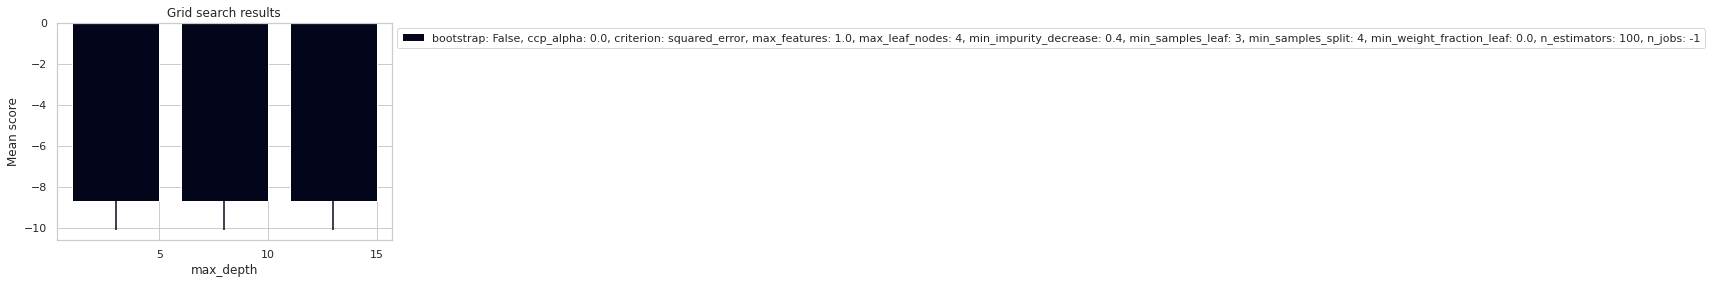

In [73]:
plot.grid_search(rand_rsearch.cv_results_, change="max_depth", kind='bar')
plt.legend(bbox_to_anchor=(1, 1));

## Gradient Boosting Regressor

In [74]:
%%time
# Instanciate model
model = GradientBoostingRegressor()

# Hyperparameter search space
search_space = {
    'learning_rate': [0.1],#[0.001,0.01,0.1],
    'n_estimators': [100],#[100,200,500,1000],
    'loss': ['squared_error'],#['squared_error', 'absolute_error', 'huber', 'quantile'],
    'subsample':[0.66],#[0.33,0.66,1.0],
    'criterion': ['friedman_mse'],#['squared_error', 'friedman_mse'],
    'min_samples_split': [7],#range(6,8,1),
    'min_samples_leaf': [3],#range(2,4,1),
    'min_weight_fraction_leaf': [0.0],#[0.0,0.1,0.2],
    'max_depth': range(2,4,1),
    'min_impurity_decrease': [0.4],#[0.3,0.4,0.5],
    'max_features': [0.7,0.8,0.9,1.0],
    'max_leaf_nodes': [4],#range(3,5,1),
    'ccp_alpha':[0.3],#[0.25,0.3,0.35],
}

# Instanciate GridSearchCV
gradboos_rsearch = GridSearchCV(
    model, search_space,
    n_jobs=-1, scoring='neg_root_mean_squared_error', cv=5, verbose=0)


gradboos_rsearch.fit(X,y)
report_best_scores(gradboos_rsearch.cv_results_, 1)

Model with rank: 1
Mean validation score: -7.555 (std: 1.089)
Parameters: {'ccp_alpha': 0.3, 'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': 0.9, 'max_leaf_nodes': 4, 'min_impurity_decrease': 0.4, 'min_samples_leaf': 3, 'min_samples_split': 7, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'subsample': 0.66}

CPU times: user 2.36 s, sys: 0 ns, total: 2.36 s
Wall time: 19.7 s


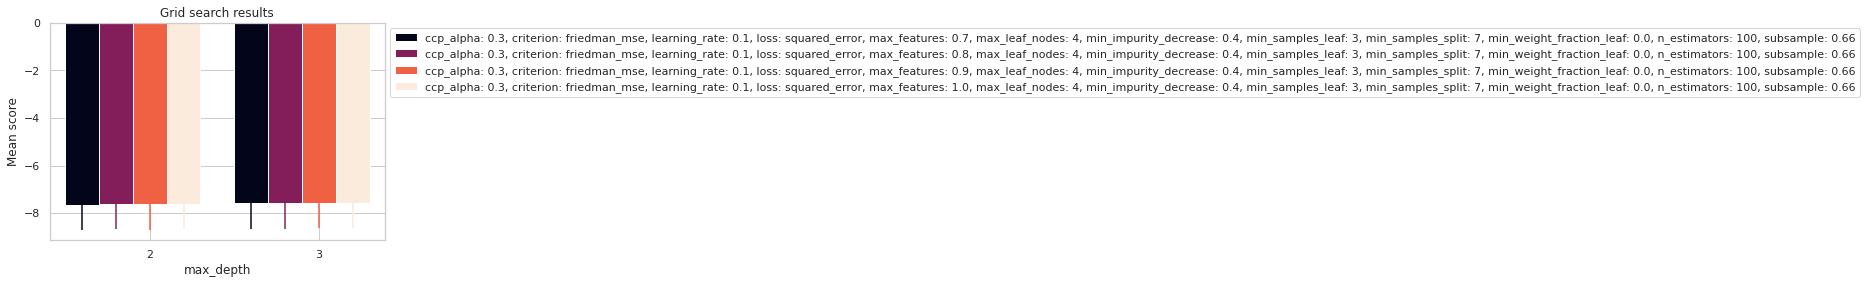

In [75]:
plot.grid_search(gradboos_rsearch.cv_results_, change="max_depth", kind='bar')
plt.legend(bbox_to_anchor=(1, 1));

## Extreme Gradient Boosting (XGB) Regressor

In [76]:
%%time
# Instanciate model
model = XGBRegressor()

# Hyperparameter search space
search_space = {
    "colsample_bytree": [0.6,0.7,0.8],
#     "gamma": [0.3,0.4,0.5],
    "learning_rate": [0.1],#[0.1,0.01,0.001], # default 0.1 
    "max_depth": range(2,4,1), # default 3
    "n_estimators": range(100,150,10), # default 100
    "subsample": [0.2],#[0.1,0.2,0.3]
}

# Instanciate GridSearchCV
xgb_rsearch = GridSearchCV(
    model, search_space,
    n_jobs=-1, scoring='neg_root_mean_squared_error', cv=5, verbose=0)


xgb_rsearch.fit(X,y)
report_best_scores(xgb_rsearch.cv_results_, 1)

Model with rank: 1
Mean validation score: -7.266 (std: 1.037)
Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 130, 'subsample': 0.2}

CPU times: user 6.35 s, sys: 0 ns, total: 6.35 s
Wall time: 54.5 s


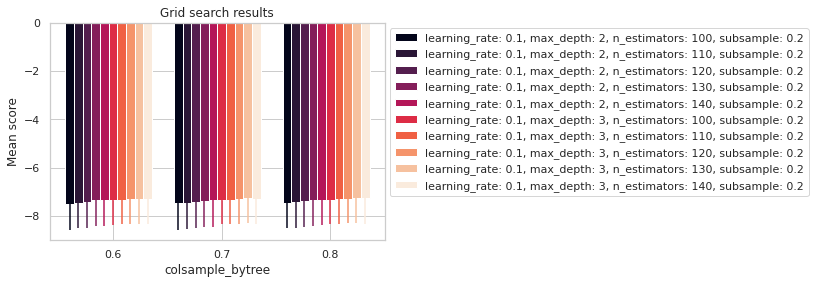

In [77]:
plot.grid_search(xgb_rsearch.cv_results_, change="colsample_bytree", kind='bar')
plt.legend(bbox_to_anchor=(1, 1));

# Building model

In [78]:
# Get transformed table with corresponding column names
X = pd.DataFrame(
                preprocessor_analysed.fit_transform(df_filtered), 
                columns=preprocessor_analysed.get_feature_names_out()
                )

y = df_filtered[target]

## Compare all models

In [79]:
kf = KFold(n_splits=5)
kf.get_n_splits(X)


scores = pd.DataFrame(columns=['model','training_time','r2','explained_variance','MSE',#'MSLE',
                               'MAE','RMSE'])

model = None
models_parametrized = [
#                 NeuralNetwork_rsearch,
                ridge_rsearch.best_estimator_,
                lasso_rsearch.best_estimator_,
    #             elastic_rsearch.best_estimator_,
    #             sgdr_rsearch.best_estimator_,
    #             knn_rsearch.best_estimator_,
    #             svm_rsearch.best_estimator_,
    #             tree_rsearch.best_estimator_,
    #             rand_rsearch.best_estimator_,
    #             gradboos_rsearch.best_estimator_,
    #             xgb_rsearch.best_estimator_,
                 ]
models_names = [type(model_foo).__name__ for model_foo in models_parametrized]
split_index = 0
for train_index, test_index in kf.split(X):
    
    # Split the data into train and test
    X_train, X_test = np.array(X)[train_index], np.array(X)[test_index]
    y_train, y_test = np.array(y)[train_index], np.array(y)[test_index]

    split_index += 1
    
    for mod_index in range(len(models_parametrized)):
        mod_name = models_names[mod_index]
        print('\n')
        print(f'Testing {mod_name} ({mod_index+1}/{len(models_parametrized)} models) on KFold split number {split_index}')

        mod = models_parametrized[mod_index]
        start = time.time()
        mod.fit(X_train,y_train)
        stop = time.time()
        training_time = stop - start

        mod_name = models_names[mod_index]

        y_pred = mod.predict(X_test)

        explained_variance=metrics.explained_variance_score(y_test, y_pred)
        mean_absolute_error=metrics.mean_absolute_error(y_test, y_pred) 
        mse=metrics.mean_squared_error(y_test, y_pred) 
    #     mean_squared_log_error=metrics.mean_squared_log_error(y_test, y_pred)
        mod_r2=metrics.r2_score(y_test, y_pred)


        scores = pd.concat([scores, pd.DataFrame.from_dict({'model':[mod_name],
                                                            'training_time':round(training_time,4),
                                     'r2':[round(mod_r2,4)],
                                     'explained_variance':[round(explained_variance,4)],
                                     'MAE':[round(mean_absolute_error,4)],
                                     'MSE':[round(mse,4)],
    #                                  'MSLE':[round(mean_squared_log_error,4)],
                                     'RMSE':[round(np.sqrt(mse),4)]   
                                    })
                           ]).reset_index(drop=True)
    



Testing Ridge (1/2 models) on KFold split number 1


Testing Lasso (2/2 models) on KFold split number 1


Testing Ridge (1/2 models) on KFold split number 2


Testing Lasso (2/2 models) on KFold split number 2


Testing Ridge (1/2 models) on KFold split number 3


Testing Lasso (2/2 models) on KFold split number 3


Testing Ridge (1/2 models) on KFold split number 4


Testing Lasso (2/2 models) on KFold split number 4


Testing Ridge (1/2 models) on KFold split number 5


Testing Lasso (2/2 models) on KFold split number 5


In [80]:
means_df = scores.groupby('model').mean().round(3)
std_df = scores.groupby('model').std().round(3)
std_df.columns= [col+'_std' for col in std_df.columns]
models_summary = pd.concat([means_df,std_df], axis=1).sort_values(by='r2', ascending=False)
print(models_summary)

       training_time     r2  explained_variance     MSE    MAE   RMSE  \
model                                                                   
Ridge          0.017  0.273               0.337  55.617  5.670  7.380   
Lasso          0.039  0.251               0.336  56.667  5.776  7.463   

       training_time_std  r2_std  explained_variance_std  MSE_std  MAE_std  \
model                                                                        
Ridge              0.006   0.093                   0.071    17.14    0.757   
Lasso              0.019   0.120                   0.071    16.00    0.654   

       RMSE_std  
model            
Ridge     1.202  
Lasso     1.102  


In [81]:
best_model = models_summary.head(1).reset_index()
best_model = best_model['model'][0]
model = models_parametrized[models_names.index(best_model)]
model

Ridge(alpha=100, tol=0)

## Create and save best prediction pipeline

In [82]:
pred_pipeline = make_pipeline(preprocessor_analysed,model)

In [83]:
pred_pipeline = pred_pipeline.fit(df_filtered.drop(columns=target),
                                  df_filtered[target])
pred_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('SimpleImputer',
                                                                   SimpleImputer()),
                                                                  ('PowerTransformer',
                                                                   PowerTransformer())]),
                                                  ['km_to_centroid',
                                                   'min_age_flatmates',
                                                   'home_total_size',
                                                   'days_available',
                                                   'room_size_house_fraction']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('SimpleImputer',
                                                                   SimpleImputer(strategy='me...
                                                                   MinMaxScaler())]),
                                                  ['transfer_costs_euros']),
                                                 ('pipeline-6',
                                                  Pipeline(steps=[('SimpleImputer',
                                                                   SimpleImputer(fill_value='no_answer',
                                                                                 strategy='constant')),
                                                                  ('OHE',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 sparse=False))]),
                                                  ['rental_length_term',
                                                   'gender_searched',
                                                   'building_type', 'heating',
                                                   'parking', 'city'])],
                                   verbose_feature_names_out=False)),
                ('ridge', Ridge(alpha=100, tol=0))])

In [84]:
# # Export Pipeline as pickle file
# with open("pred_pipeline_allcities.pkl", "wb") as file:
#     pickle.dump(pred_pipeline, file)

# # Load Pipeline from pickle file
# pred_pipeline = pickle.load(open("pred_pipeline_allcities.pkl","rb"))

## Learning curve best prediction pipeline

In [85]:
# Range for training with 10 equally devided points
train_sizes_range = range(int(round(len(y)/10,-2)), 
                          len(y)-int(round(len(y)/10,-2)),
                          int(round(len(y)/10,-2)))

# Get train scores, train sizes, and validation scores using `learning_curve`, r2 score
train_sizes, train_scores, test_scores = learning_curve(estimator = model,
                                                              X = X, 
                                                              y = y, 
                                                              train_sizes = train_sizes_range, 
                                                              cv = 10,
                                                              scoring = 'neg_root_mean_squared_error')

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

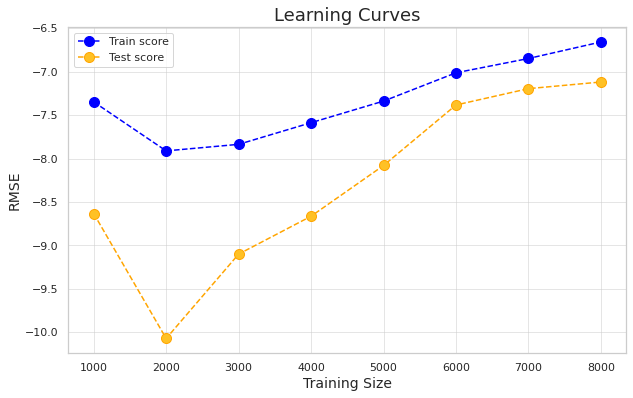

In [86]:
# Plot the learning curves

with plt.style.context('seaborn-deep'):
    # figsize
    plt.figure(figsize=(10,6))
    # getting axes
    ax = plt.gca()
    # plotting
    ax.plot(train_sizes, train_scores_mean, label = 'Train score',color='blue', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=10)
    ax.plot(train_sizes, test_scores_mean, label = 'Test score',color='orange', linestyle='dashed', marker='o',markerfacecolor='#ffc125', markersize=10)
    # more
    ax.set_title('Learning Curves', fontsize = 18)
    ax.set_xlabel('Training Size', fontsize = 14)
    ax.set_ylabel('RMSE', fontsize = 14)
    ax.grid(axis="x",linewidth=0.5)
    ax.grid(axis="y",linewidth=0.5)
    ax.legend(loc="best")
    
    plt.show()

RMSE: 6.58510288087736
RMSE base model (mean value): 9.461499757114446


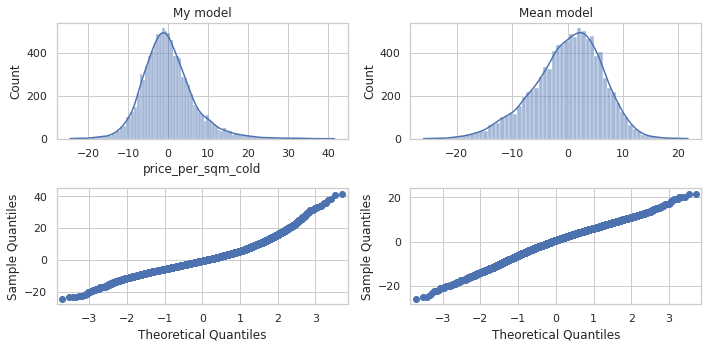

In [87]:
import statsmodels.api as sm
y_pred = pred_pipeline.predict(df_filtered)
y_base = [np.mean(y)]*len(y_pred)
y_true = y#y_test

print(f'RMSE: {np.sqrt(((y_pred - y_true) ** 2).mean())}')
print(f'RMSE base model (mean value): {np.sqrt(((y_base - y_true) ** 2).mean())}')

n=len(y_pred)
residuals = y_true - y_pred
residuals_base = y_base - y_pred

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))
sns.histplot(residuals, kde=True, edgecolor='w', ax=ax1).set(title='My model')
sns.histplot(residuals_base, kde=True, edgecolor='w', ax=ax2).set(title='Mean model')

# https://stats.stackexchange.com/questions/101274/how-to-interpret-a-qq-plot
sm.qqplot(residuals, ax=ax3)
sm.qqplot(residuals_base, ax=ax4)
plt.tight_layout()
fig.show();

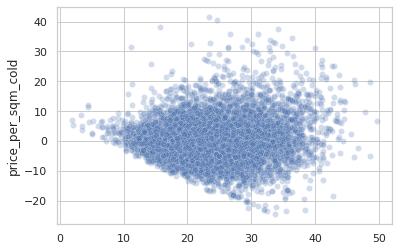

In [88]:
sns.scatterplot(x=y_pred, y=residuals,alpha=0.25);

# Simple linear model

In [89]:
X = pd.DataFrame(
                preprocessor_transformer.fit_transform(df_filtered), 
                columns=preprocessor_transformer.get_feature_names_out()
                )
y = df_filtered[[target]].reset_index()
df_OLS=pd.concat([y,X],axis=1).set_index(keys='id')

# Select data from a specified time period
df_OLS = pd.merge(ads_feat_df['published_on'], df_OLS, left_index=True, right_index=True)
# df_OLS = df_OLS[df_OLS['published_on'] <= '2022-08-01']
# df_OLS = df_OLS[df_OLS['published_on'] > '2022-08-08']

df_OLS.columns = [cols.replace(' ','_') for cols in df_OLS.columns.to_list()]

In [90]:
print(df_OLS.shape)
df_OLS.describe()

(9576, 153)


,price_per_sqm_cold,km_to_centroid,min_age_flatmates,max_age_flatmates,home_total_size,days_available,room_size_house_fraction,energy_usage,comfort_leisure_spots,comfort_warehouse,activities_education,mobility_public_transport_bus,activities_economic,comfort_industrial,social_life_eating,comfort_comfort_spots,social_life_culture,social_life_community,comfort_leisure_mass,activities_educational,mobility_street_secondary,mobility_public_transport_rail,activities_retail,social_life_night_life,comfort_railway,mobility_bike_infraestructure,mobility_street_primary,comfort_lakes,activities_health_local,comfort_green_space,activities_post,comfort_green_parks,capacity,min_age_searched,max_age_searched,public_transport_distance,number_languages,energy_efficiency_class,internet_speed,sin_degrees_to_centroid,cos_degrees_to_centroid,commercial_landlord,male_flatmates,female_flatmates,diverse_flatmates,flat_with_kids,schufa_needed,smoking_numerical,building_floor,furniture_numerical,tv_kabel,tv_satellit,shower_type_badewanne,shower_type_dusche,floor_type_dielen,floor_type_parkett,floor_type_laminat,floor_type_teppich,floor_type_fliesen,floor_type_pvc,floor_type_fußbodenheizung,extras_waschmaschine,extras_spuelmaschine,extras_terrasse,extras_balkon,extras_garten,extras_gartenmitbenutzung,extras_keller,extras_aufzug,extras_haustiere,extras_fahrradkeller,extras_dachboden,languages_deutsch,languages_englisch,wg_type_studenten,wg_type_keine_zweck,wg_type_maenner,wg_type_business,wg_type_wohnheim,wg_type_vegetarisch_vegan,wg_type_alleinerziehende,wg_type_funktionale,wg_type_berufstaetigen,wg_type_gemischte,wg_type_mit_kindern,wg_type_verbindung,wg_type_lgbtqia,wg_type_senioren,wg_type_inklusive,wg_type_wg_neugruendung,internet_dsl,internet_wlan,internet_flatrate,transfer_costs_euros,rental_length_term_180days,rental_length_term_270days,rental_length_term_30days,rental_length_term_365days,rental_length_term_540days,rental_length_term_90days,rental_length_term_plus540days,gender_searched_Divers,gender_searched_Egal,gender_searched_Frau,gender_searched_Mann,building_type_Altbau,building_type_Doppelhaus,building_type_Einfamilienhaus,building_type_Hochhaus,building_type_Mehrfamilienhaus,building_type_Neubau,building_type_Plattenbau,building_type_Reihenhaus,building_type_no_answer,building_type_sanierter_Altbau,heating_Fernwärme,heating_Gasheizung,heating_Kohleofen,heating_Nachtspeicherofen,heating_Ofenheizung,heating_Zentralheizung,heating_no_answer,parking_Bewohnerparken,parking_Tiefgaragenstellplatz,parking_eigener_Parkplatz,parking_gute_Parkmöglichkeiten,parking_no_answer,parking_schlechte_Parkmöglichkeiten,city_Aachen,city_Berlin,city_Bonn,city_Bremen,city_Darmstadt,city_Dresden,city_Frankfurt_am_Main,city_Göttingen,city_Hamburg,city_Hannover,city_Heidelberg,city_Karlsruhe,city_Kiel,city_Köln,city_Leipzig,city_Mainz,city_Mannheim,city_München,city_Münster,city_Nürnberg,city_Regensburg,city_Stuttgart,city_Tübingen,city_Würzburg
count,9576.000000,9.576000e+03,9.576000e+03,9.576000e+03,9.576000e+03,9.576000e+03,9.576000e+03,9.576000e+03,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9.576000e+03,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.00000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.00000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000000,9576.000

In [91]:
# OLS model
formula = target + ' ~ ' + ' + '.join(str(feat) for feat in df_OLS.columns if feat not in [target,'published_on','languages_deutsch']) +' -1'

model = smf.ols(formula = formula, data=df_OLS).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     price_per_sqm_cold   R-squared:                       0.531
Model:                            OLS   Adj. R-squared:                  0.524
Method:                 Least Squares   F-statistic:                     74.11
Date:                Wed, 14 Sep 2022   Prob (F-statistic):               0.00
Time:                        20:40:34   Log-Likelihood:                -31483.
No. Observations:                9576   AIC:                         6.326e+04
Df Residuals:                    9431   BIC:                         6.430e+04
Df Model:                         144                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
km_to_centroid                         -0.4370      0.114     -3.818      0.000      -0.661      -0.213
min_age_flatmates                      -0.1241      0.087     -1.426      0.154      -0.295       0.046
max_age_flatmates                      -0.4157      0.091     -4.552      0.000      -0.595      -0.237
home_total_size                        -3.9245      0.105    -37.355      0.000      -4.130      -3.719
days_available                          1.3954      0.369      3.779      0.000       0.672       2.119
room_size_house_fraction               -5.2507      0.097    -54.344      0.000      -5.440      -5.061
energy_usage                           -0.0427      0.068     -0.627      0.531      -0.176       0.091
comfort_leisure_spots                  -0.1380      0.224     -0.616      0.538      -0.577       0.301
comfort_warehouse                       0.2059      0.211      0.974      0.330      -0.209       0.620
activities_education                    0.3369      0.420      0.803      0.422      -0.486       1.160
mobility_public_transport_bus          -1.3074      0.376     -3.476      0.001      -2.045      -0.570
activities_economic                     0.0340      0.314      0.108      0.914      -0.581       0.649
comfort_industrial                     -0.3732      0.252     -1.483      0.138      -0.866       0.120
social_life_eating                      2.4132      0.486      4.964      0.000       1.460       3.366
comfort_comfort_spots                  -0.0971      0.265     -0.366      0.714      -0.616       0.422
social_life_culture                    -1.6660      0.575     -2.895      0.004      -2.794      -0.538
social_life_community                  -0.1914      0.320     -0.598      0.550      -0.818       0.436
comfort_leisure_mass                    0.4474      0.474      0.944      0.345      -0.482       1.377
activities_educational                 -0.2813      0.265     -1.061      0.289      -0.801       0.239
mobility_street_secondary               0.1848      0.334      0.554      0.579      -0.469       0.839
mobility_public_transport_rail         -0.9305      0.901     -1.033      0.302      -2.696       0.835
activities_retail                      -0.3041      0.299     -1.018      0.309      -0.890       0.281
social_life_night_life                 -0.0192      0.438     -0.044      0.965      -0.877       0.839
comfort_railway                         0.8014      0.277      2.896      0.004       0.259       1.344
mobility_bike_infraestructure          -0.6191      0.204     -3.034      0.002      -1.019      -0.219
mobility_street_primary                 0.9572      0.229      4.177      0.000       0.508       1.406
comfort_lakes                           0.0482      0.212      0.22

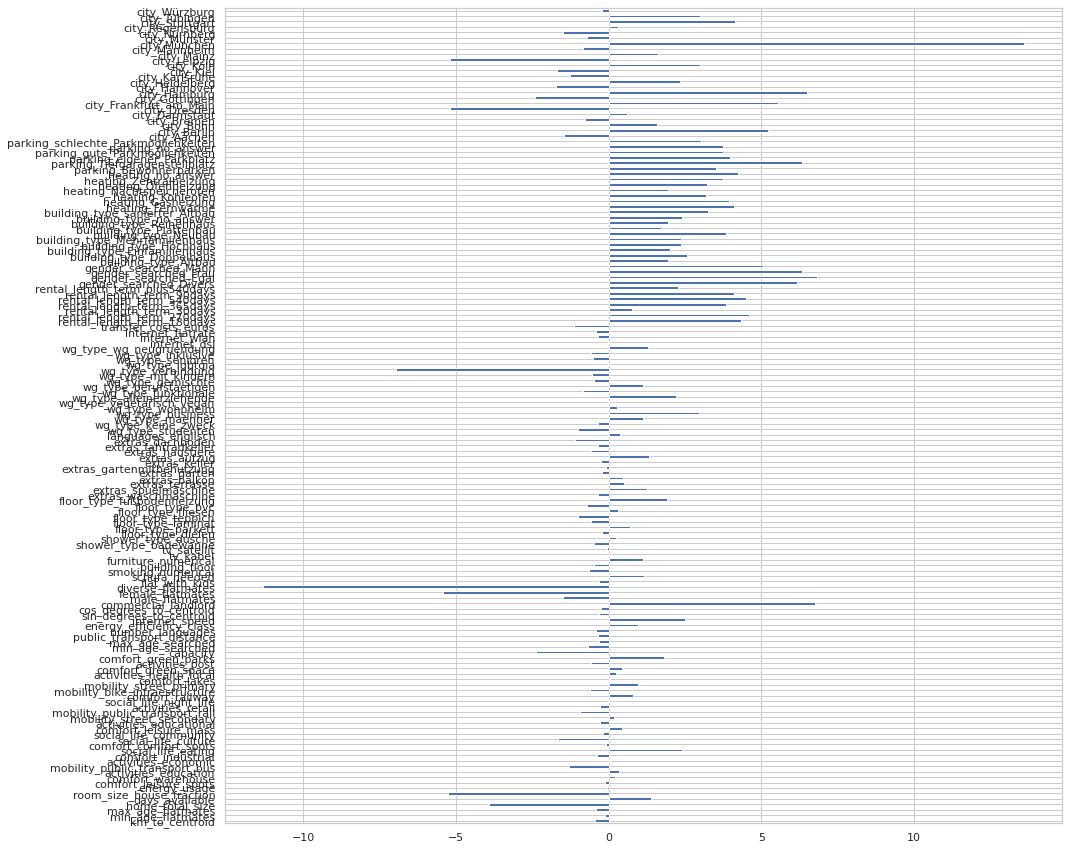

In [92]:
sns.set_theme(style = "whitegrid", font_scale= 1)
fig = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))

model.params[0:].plot(kind='barh');

RMSE: 6.480567790091196
RMSE base model: 9.461499757114446


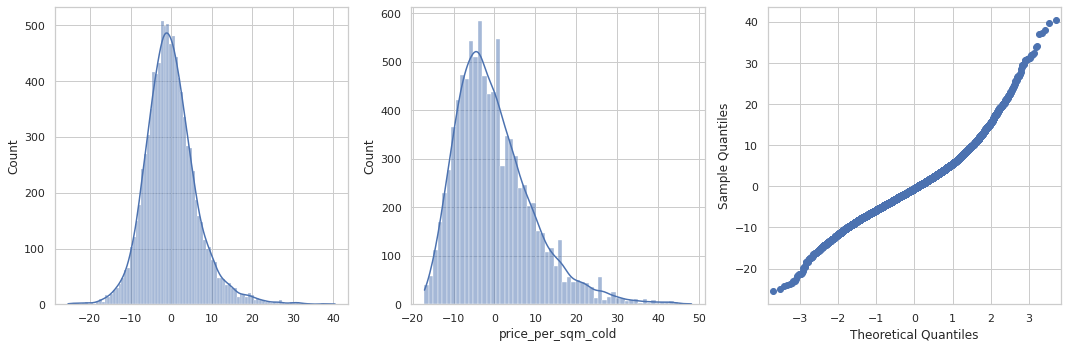

In [94]:
df_city = df_OLS#[df_OLS['city_hannover'] == 1.0]
y_pred = model.predict(df_city)
y_base = [np.mean(df_city[target])]*len(y_pred)
y_true = df_city[target]

print(f'RMSE: {np.sqrt(((y_pred - y_true) ** 2).mean())}')
print(f'RMSE base model: {np.sqrt(((y_base - y_true) ** 2).mean())}')

n=len(df_processed)
residuals = y_true - y_pred 
residuals_base = y_true - y_base

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
sns.histplot(residuals, kde=True, edgecolor='w', ax=ax1)
sns.histplot(residuals_base, kde=True, edgecolor='w', ax=ax2)

# https://stats.stackexchange.com/questions/101274/how-to-interpret-a-qq-plot
sm.qqplot(model.resid, ax=ax3)
plt.tight_layout()
fig.show();

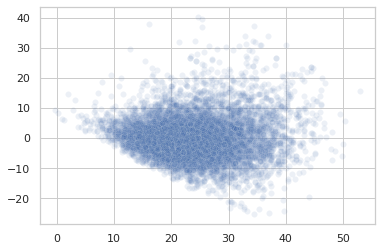

In [95]:
sns.scatterplot(x=y_pred, y=residuals,alpha=0.1);

                                    p_value       coef
variable                                              
city_München                   0.000000e+00  13.590883
gender_searched_Egal           2.227943e-65   6.810947
commercial_landlord            1.308184e-16   6.766862
city_Hamburg                   2.618500e-76   6.490715
parking_Tiefgaragenstellplatz  1.235770e-22   6.343370
...                                     ...        ...
city_Dresden                   1.478111e-33  -5.209645
room_size_house_fraction       0.000000e+00  -5.250703
female_flatmates               7.548867e-05  -5.442001
wg_type_verbindung             2.254792e-11  -6.980262
diverse_flatmates              1.536821e-02 -11.329418

[90 rows x 2 columns]


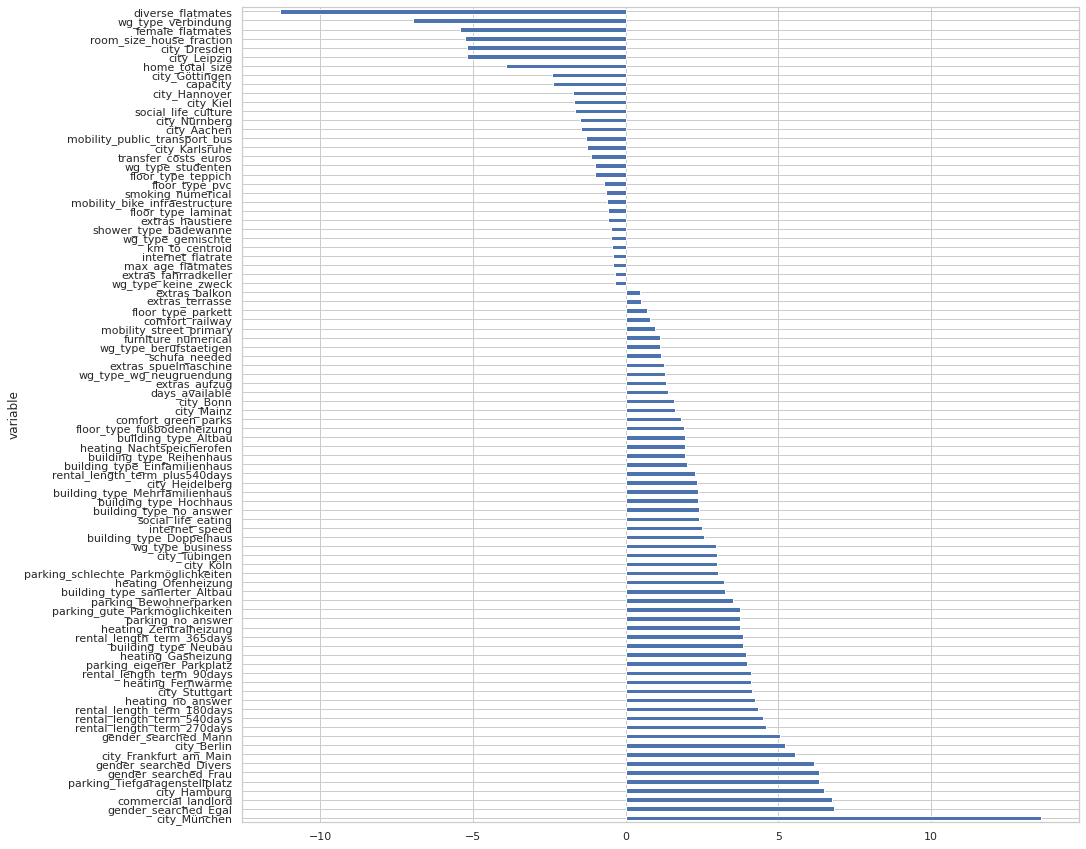

In [96]:
df = return_significative_coef(model).set_index('variable')
print(df)

sns.set_theme(style = "whitegrid", font_scale= 1)
fig = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
df.coef.plot(kind='barh');